In [2]:
import anndata, pickle, os, fnmatch, math, random, copy
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator, LogLocator, LogFormatter, LogFormatterSciNotation, MaxNLocator
import matplotlib.patches as mpatches

In [3]:
'''ADDING PLOTTING PARAMETERS SO EXPORTED IMAGES ARE COMPATIBLE WITH ILLUSTRATOR'''

# Code from: https://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/
mlp.rcParams['pdf.fonttype'] = 42
mlp.rcParams['ps.fonttype'] = 42

In [4]:
'''IMPORTING NECESSARY FUNCTIONS FROM GENERAL FUNCTION FILE'''

%run GeneralFunctions.ipynb

In [5]:
'''NON-PLOTTING FUNCTIONS USED IN THIS FILE'''

def dotPlotCalcs(dictLst, sampleLsts, VC_colorLst, AC_colorLst, mouseSex):
    # Sample data
    sample_labels = []
    counts = []
    groupColors = []
    VC_colorLst_copy = copy.deepcopy(VC_colorLst)
    AC_colorLst_copy = copy.deepcopy(AC_colorLst)
    vc_diffColor = VC_colorLst_copy.pop(3)
    ac_diffColor = AC_colorLst_copy.pop(3)
    
    for dictionary, sampleComparLst, vc_color, ac_color in zip(dictLsts, sampleLsts, VC_colorLst_copy, AC_colorLst_copy):
        for i in range(len(sampleComparLst)):
            if len(sampleComparLst[0]) == 2:
                condition = sampleComparLst[i][0]
                sampleName = sampleComparLst[i][1]
                sampleNum = sampleName[:-6]
                sampleLabel = f'{condition} ({sampleNum})'
                sameSex = True
                dictName = sampleName
            else:    
                condition = sampleComparLst[i][0]
                sample1_name = sampleComparLst[i][1]
                sample2_name = sampleComparLst[i][2]
                sample1_num = sample1_name[:-6]
                sample2_num = sample2_name[:-6]
                sampleLabel = f'{condition} ({sample1_num} vs. {sample2_num})'
                sameSex = comaringSex(sample1_name, sample2_name)    
                dictName = f'{sample1_name}_{sample2_name}'
                
            countLst = dictionary[dictName]

            if sameSex or mouseSex == None: 
                counts.append(countLst)
                sample_labels.append(f'{sampleLabel}')
                if 'VC' in sampleLabel:
                    if ('MD' in condition) and ('vs.' in condition): 
                        groupColors.append(vc_diffColor)
                    else: groupColors.append(vc_color)
                else:
                    if ('MD' in condition) and ('vs.' in condition): 
                        groupColors.append(ac_diffColor)
                    else: groupColors.append(ac_color) 

    # Generate random x and y coordinates for each dot in each sample
    x_coords = []
    y_coords = []
    pointColors = []
    y = 0
    for lst, color in zip(counts, groupColors):
        y += 1
        for num in lst:
            jitter = random.uniform(-0.1, 0.1)
            y_coords.append(y + jitter)
            x_coords.append(num)
            pointColors.append(color)
    
    return(x_coords, y_coords, pointColors, sample_labels)



In [6]:
'''PLOTTING FUNCTIONS USED IN THIS FILE'''

# Histogram: Number of Genes vs. Mean Count 
    # sampleObj = the sample's AnnData object you want to plot the mean_counts for 
    # ax = the axis object for subplot
def geneCountHist(sampleObj, ax):
    counts, edges, _ = ax.hist(sampleObj.var['mean_counts'], bins=100)
    maxCount = max(counts)
    ax.text(0.95, 0.95, f'Max # of Genes = {maxCount}', fontsize=20, ha='right', va='top', transform=ax.transAxes)
    ax.set_xscale('log')
    ax.set_xlabel('Mean Counts', fontsize = 20)
    ax.set_ylabel('Number of Genes', fontsize = 20)
    ax.set_ylim(top = 25000, bottom = 0)

# Dot Plot: Sample vs. Number of DE Genes 
    # figSize = tuple containing the size you want your figure to be (W, H)
    # x_coords = list containing all of the dot's x coordinates (obtained through 'dotPlotCalcs' function)
    # y_coords = list containing all of the dot's y coordinates (obtained through 'dotPlotCalcs' function)
    # pointColors = list containing each point's color (obtained through 'dotPlotCalcs' function) 
    # sample_labels = list containing the label for each sample (y axis) (obtained through 'dotPlotCalcs' function)
    # VC_colorLst = list containing the colors for each group of VC samples 
    # AC_colorLst = list containing the colors for each group of AC samples 
    # graphName = string of the name you want to use to save the image 
    # title = string of the addition you want to make to the title 
def createDotPlot(figSize, x_coords, y_coords, pointColors, sample_labels, VC_colorLst, AC_colorLst, graphName, title):
    # Create the dot plot
    fig, ax = plt.subplots(figsize=figSize)
    axis_fontsize = 35
    label_fontsize = 30
    title_fontsize = 40


    for x, y, color in zip(x_coords, y_coords, pointColors):
        ax.scatter(x, y, s=125, color=color)

    line_x = [0, 0]
    line_y = [0, (len(sample_labels))]  # Y-coordinates of the line endpoints
    ax.plot(line_x, line_y, color='lightgray', linewidth=1)    

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xlim(-10, 100)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Number of Genes', fontsize=axis_fontsize)
    ax.tick_params(axis='x', labelsize=30)

    ax.set_yticks([i for i in range(1, (len(sample_labels)+1))], sample_labels, fontsize=label_fontsize)
    ax.set_ylabel('Sample Comparisons', fontsize=axis_fontsize)

    ax.set_title(f'Number of Genes per Cluster with DE Score >20 or <-20 and a Fold Change >2 or <0.5 for {title}', 
                 fontsize=title_fontsize, y=1.07)

    patchA = mpatches.Patch(color=VC_colorLst[0], label='VC Within Sample Comparisons')
    patchB = mpatches.Patch(color=AC_colorLst[0], label='AC Within Sample Comparisons')
    patchC = mpatches.Patch(color=VC_colorLst[1], label='VC Biological Replicates')
    patchD = mpatches.Patch(color=AC_colorLst[1], label='AC Biological Replicates')
    patchE = mpatches.Patch(color=VC_colorLst[3], label='VC Plasticity Comparisons')
    patchF = mpatches.Patch(color=AC_colorLst[3], label='AC Plasticity Comparisons')
    patchG = mpatches.Patch(color=VC_colorLst[4], label='VC Hemispheric Comparisons')
    patchH = mpatches.Patch(color=AC_colorLst[4], label='AC Hemispheric Comparisons')
    ax.legend(handles=[patchA, patchB, patchC, patchD, patchE, patchF, patchG, patchH], loc='lower right', 
              fontsize=label_fontsize)

    plt.show(False)
    # Saving figure
    plt.savefig(os.path.join('F:/Figures/Figure4/', f'{graphName}.pdf'), bbox_inches = 'tight', transparent=True)
    

## Preliminary Graph for Figure 4

In [44]:
'''SAMPLE COMPARISON LISTS'''

sampleNameLst = [['MD Contra. Hem. (L)', '1_VC20L'], ['MD Contra. Hem. (L)', '2_AC20L'], ['MD Ipsi. Hem. (R)', '3_VC20R'], 
                 ['MD Ipsi. Hem. (R)', '4_AC20R'], ['Deafened', '5_VC22L'], ['Deafened', '6_AC22L'], ['Control', '7_VC24L'],
                 ['Control', '8_AC24L'], ['Control', '9_VC23L'], ['Deafened', '10_VC25L'], ['Deafened', '13_AC25L'], 
                 ['Control', '14_AC23L'], ['MD Contra. Hem. (L)', '16_VC19L'], ['MD Ipsi. Hem. (R)', '17_VC19R'], 
                 ['MD Contra. Hem. (L)', '19_AC19L'], ['MD Ipsi. Hem. (R)', '20_AC19R']]

bioRepComparisonLst = [['Control', '7_VC24L', '9_VC23L'], ['Control', '8_AC24L', '14_AC23L'], 
                       ['Deafened', '5_VC22L', '10_VC25L'], ['Deafened', '6_AC22L', '13_AC25L'], 
                       ['MD Contra. Hem. (L)', '16_VC19L', '1_VC20L'], ['MD Contra. Hem. (L)', '19_AC19L', '2_AC20L'], 
                       ['MD Ipsi. Hem. (R)', '17_VC19R', '3_VC20R'], ['MD Ipsi. Hem. (R)', '20_AC19R', '4_AC20R']]

plastComparLst = [['Deaf VC vs. Control VC', '5_VC22L', '7_VC24L'], ['Deaf VC vs. Control VC', '5_VC22L', '9_VC23L'], 
                  ['Deaf VC vs. Control VC', '10_VC25L', '7_VC24L'], ['Deaf VC vs. Control VC', '10_VC25L', '9_VC23L'],
                  ['Deaf AC vs. Control AC', '6_AC22L', '8_AC24L'], ['Deaf AC vs. Control AC', '6_AC22L', '14_AC23L'],
                  ['Deaf AC vs. Control AC', '13_AC25L', '8_AC24L'], ['Deaf AC vs. Control AC', '13_AC25L', '14_AC23L'],
                  ['MD VC vs. Control VC', '16_VC19L', '7_VC24L'], ['MD VC vs. Control VC', '16_VC19L', '9_VC23L'],
                  ['MD VC vs. Control VC', '1_VC20L', '7_VC24L'], ['MD VC vs. Control VC', '1_VC20L', '9_VC23L'],
                  ['MD AC vs. Control AC', '19_AC19L', '8_AC24L'], ['MD AC vs. Control AC', '19_AC19L', '14_AC23L'],
                  ['MD AC vs. Control AC', '2_AC20L', '8_AC24L'], ['MD AC vs. Control AC', '2_AC20L', '14_AC23L']]

hemComparLst = [['VC Contra (L) vs. Ipsi Hem (R)', '16_VC19L', '17_VC19R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '19_AC19L', '20_AC19R'], 
                ['VC Contra (L) vs. Ipsi Hem (R)', '1_VC20L', '3_VC20R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '2_AC20L','4_AC20R']]

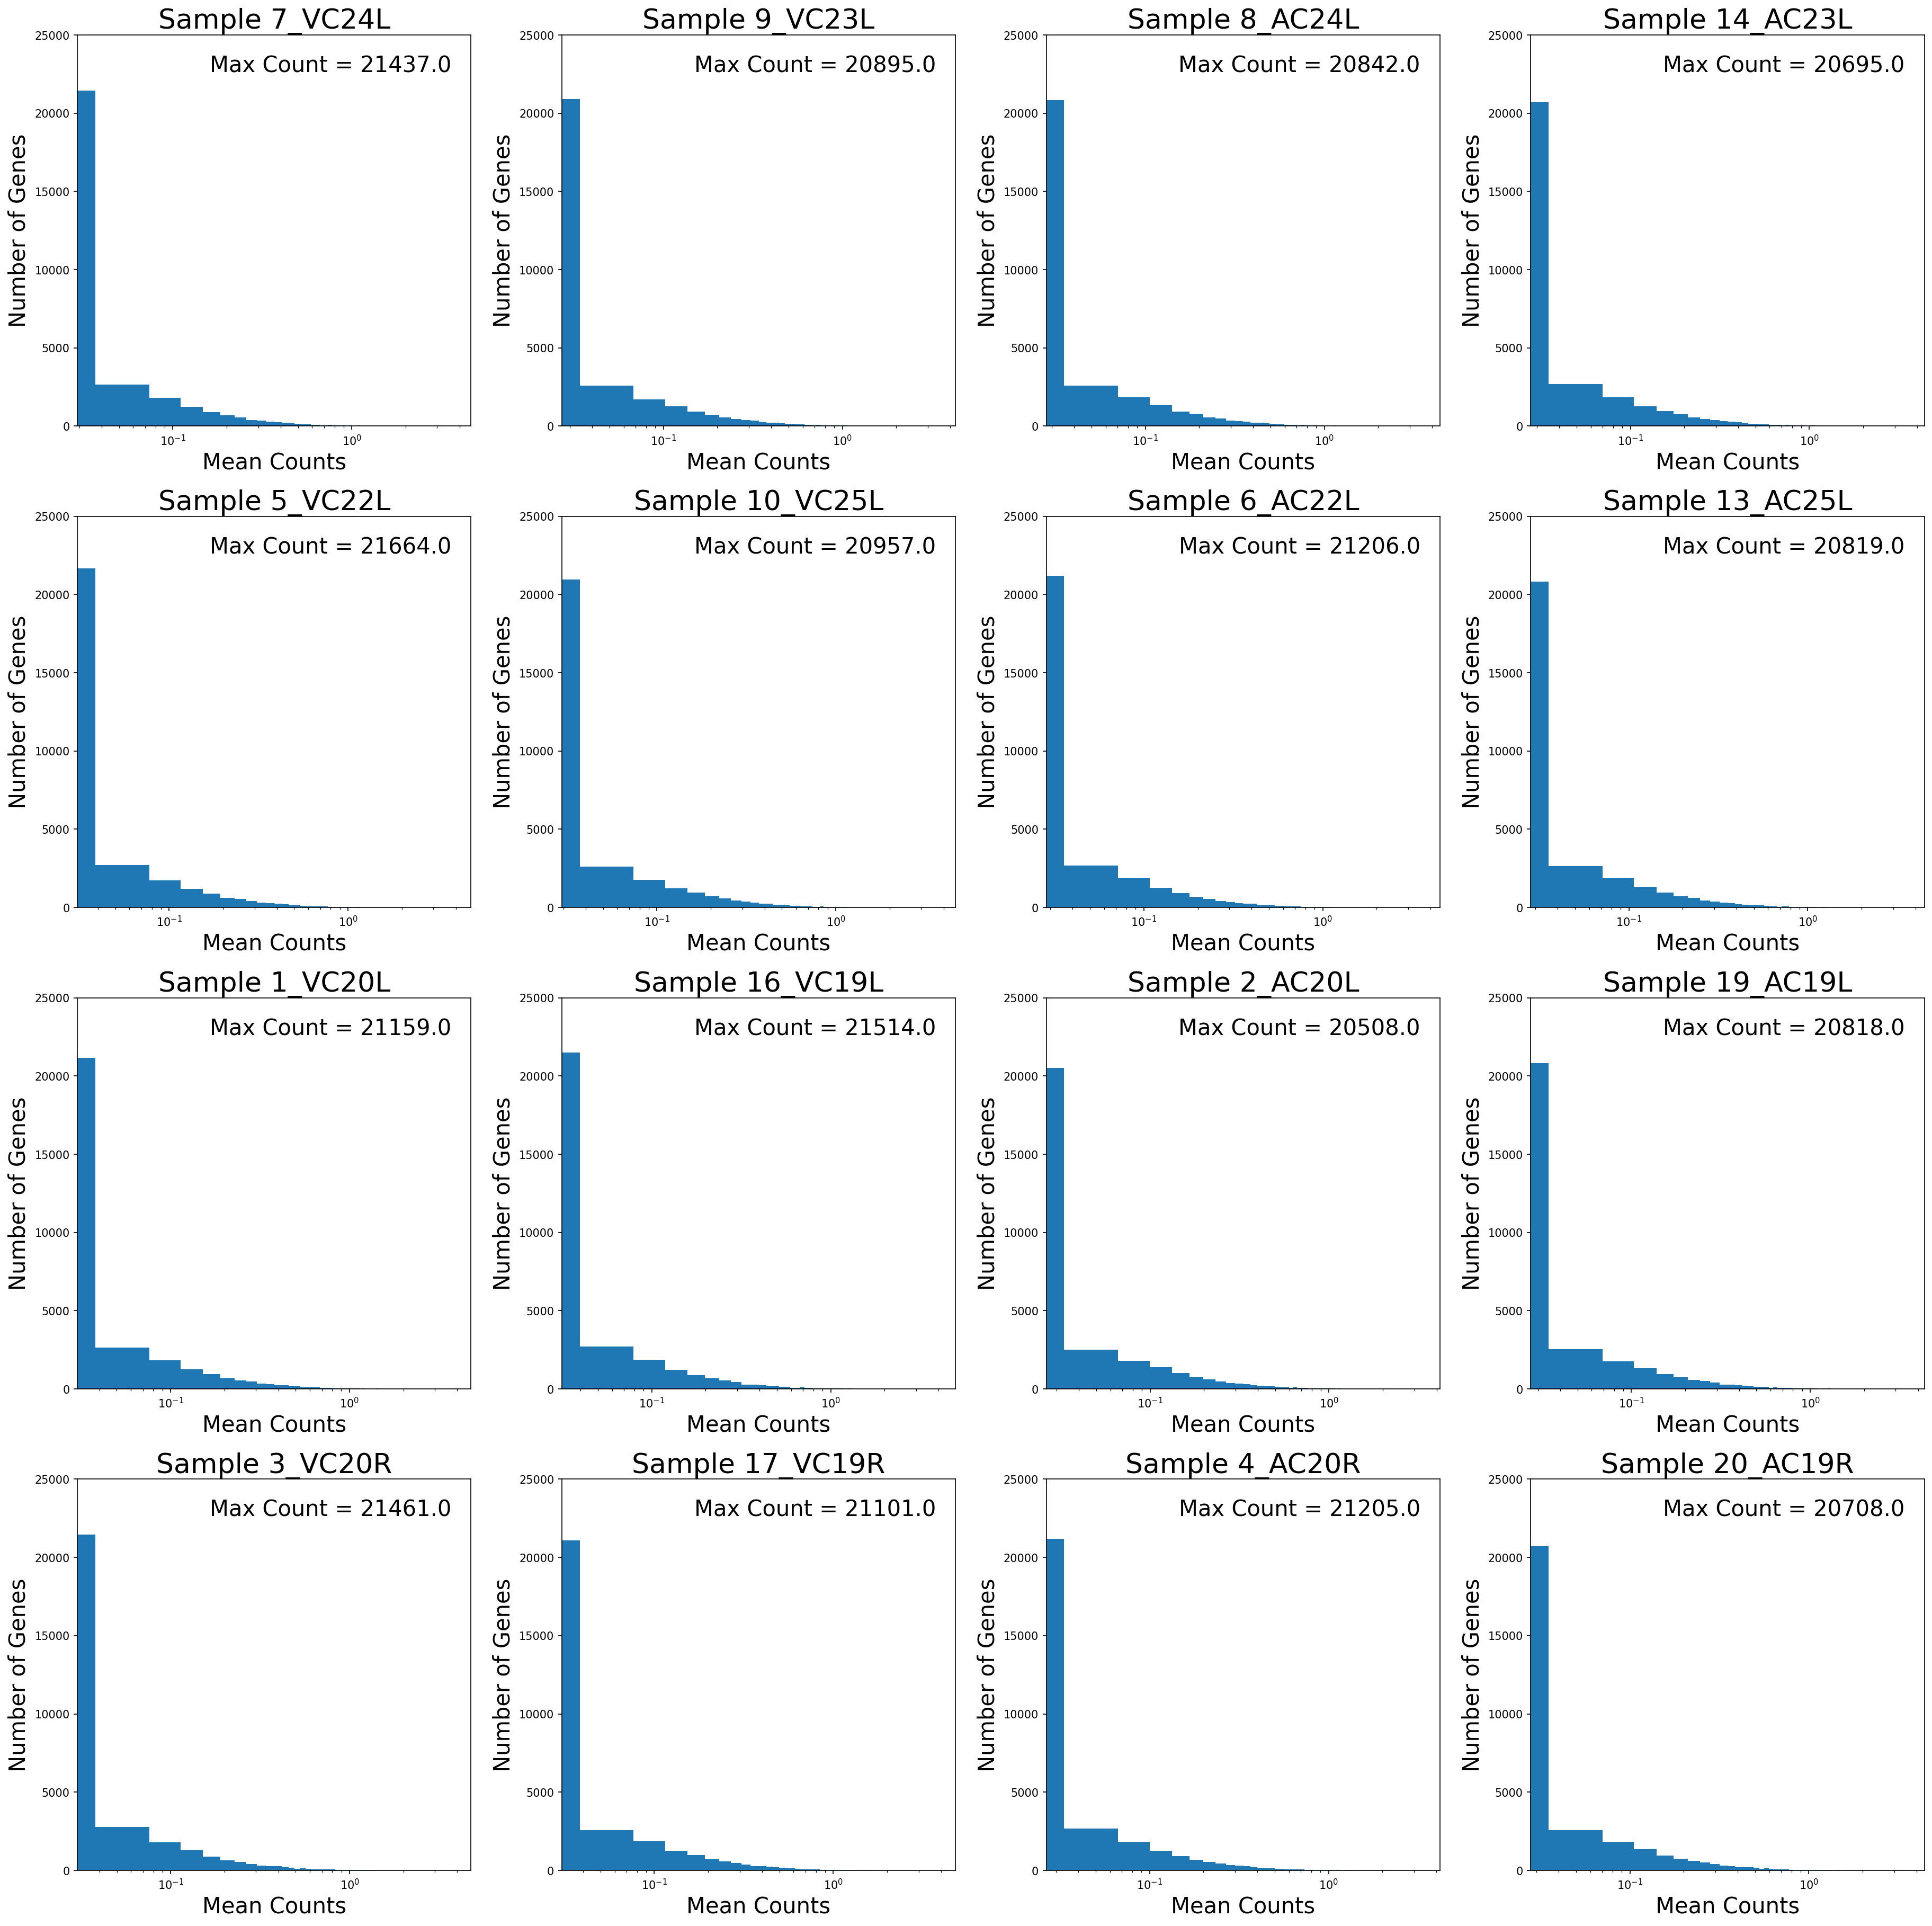

In [10]:
'''MAX GENE COUNT PER SAMPLE'''

# Create a figure with non-grid subplots
fig = plt.figure(figsize=(30,30), dpi=150)       

# Define the size and position of each subplot using subplot2grid
row = 8
col = 8

fig, axs = plt.subplots(rows, cols, figsize=(30,30), dpi=150)

for i_row in range(rows):
    for i_col in range(cols):
        
        sampleLst = sampleNameLst[0]
        condition = sampleLst[0]
        sampleName = sampleLst[1]
        filePath = f'F:/SampleData/IndividualSamples/{sampleName}.h5ad'
        sampleObj = sc.read(filePath)
        
        axsObj = axs[i_row, i_col] 
        geneCountHist(sampleObj, axsObj)
        axsObj.set_title(f'Sample {sampleName}', fontsize = 25)

        sampleNameLst.pop(0)
        
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.6)

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = 

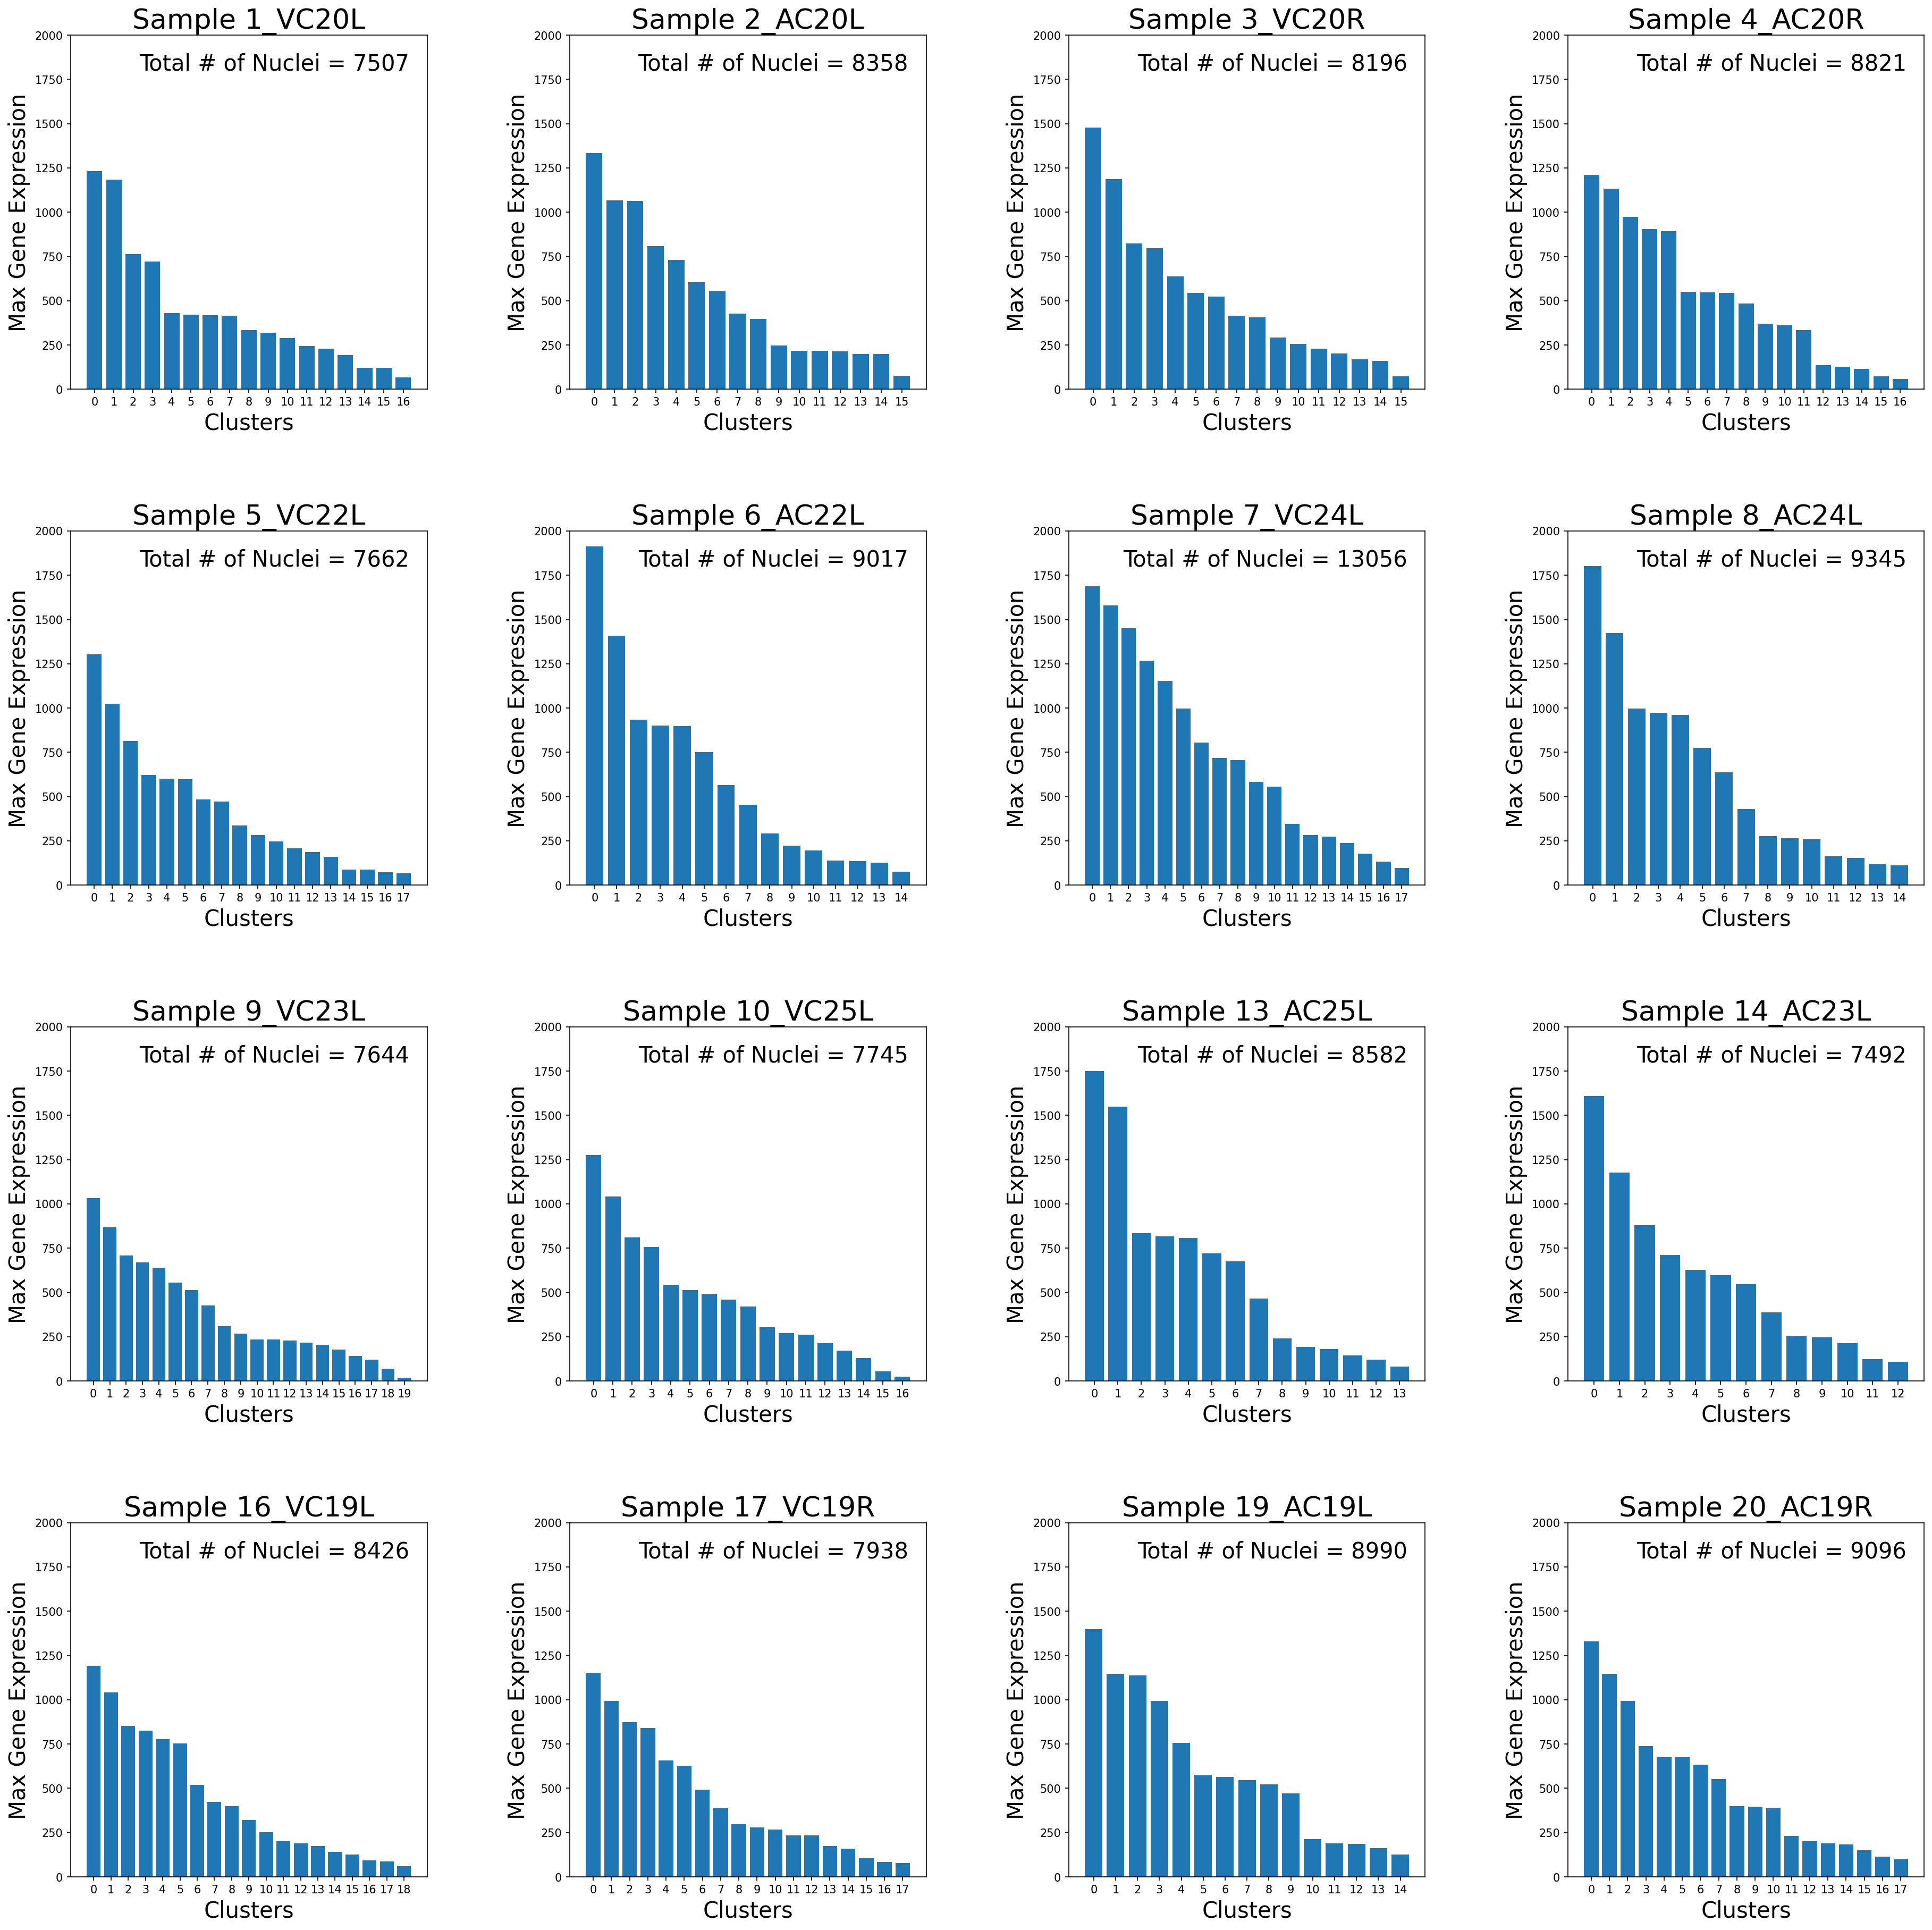

In [23]:
'''TOTAL NUCLEI PER CLUSTER AND PER CLUSTER'''

rows = 4
cols = 4 

fig, axs = plt.subplots(rows, cols, figsize=(30,30), dpi=150)

for i_row in range(rows):
    for i_col in range(cols):
            sampleLst = sampleNameLst[0]
            sampleName = sampleLst[1]

            obj = sc.read(f"F:/SampleData/IndividualSamples/{sampleName}.h5ad")

            clustLst = list(np.unique(obj.obs['leiden_0.3']))
            sortClustLst = sortClust(clustLst)

            nucCount = []

            for clust in sortClustLst:
                clustObj = obj[obj.obs['leiden_0.3'].isin([clust]),:]
                sc.pp.calculate_qc_metrics(clustObj, percent_top=None, log1p=False, inplace=True)

                clustNucCount = clustObj.n_obs
                nucCount.append(clustNucCount)
            
            axObj = axs[i_row, i_col]
            axObj.bar(sortClustLst, nucCount)
            axObj.set_ylim(0, 2000)
            axObj.text(0.95, 0.95, f'Total # of Nuclei = {obj.n_obs}', fontsize=20, ha='right', va='top', 
                    transform=axObj.transAxes)
            axObj.set_xlabel('Clusters', fontsize = 20)
            axObj.set_ylabel('Max Gene Expression', fontsize = 20)
            axObj.set_title(f'Sample {sampleName}', fontsize = 25)
            
            sampleNameLst.pop(0)
            
plt.subplots_adjust(hspace=0.4, wspace=0.4)

## DE Score vs. Fold Change

In [48]:
def diffExpVSfoldChange(foldChangeDict, sampleComparLst, folderName):
    
    if (len(sampleComparLst)/4) != 1:
        cols = 4
        rows = int(len(sampleComparLst)/cols)
    else:
        cols = 2
        rows = 2
    
    size = ()
    
    if cols == 2: size = (20, 20)
    elif rows < 4: size = (30, 15) 
    elif rows == 4: size = (30, 30)
    else: size = (30, 40)
    
    fig, axs = plt.subplots(rows, cols, figsize=size, dpi=150)

    for i_row in range(rows):
        for i_col in range(cols):
            sampleLst = sampleComparLst[0]
            
            if len(sampleLst) == 2:     
                condition = sampleLst[0]
                sampleName = sampleLst[1]
                
                deScore = f'{sampleName} Half 1_DE_Score'
                title = f'Sample {sampleName}'
                
            else:
                condition = sampleLst[0]
                sample1_name = sampleLst[1]
                sample2_name = sampleLst[2]
                sample1_num = sample1_name[:-6]
                sample2_num = sample2_name[:-6]
                cortex = sample1_name[-5:-3]
                
                sampleName = f'{condition}_{sample1_name}_{sample2_name}'
                deScore = f'{sample1_name}_DE_Score'
                title = f'{cortex} {condition} ({sample1_num} vs. {sample2_num})'
                
            axObj = axs[i_row, i_col]

            obj = sc.read(f'F:/SampleData/{folderName}/{sampleName}.h5ad')

            foldChange = dictionary[sampleName]
            diffExp = obj.var[deScore]

            axObj.scatter(foldChange, diffExp)
            axObj.set_xlabel('Fold Change', fontsize = 20)
            axObj.set_ylabel('Differential Expression', fontsize = 20)
            axObj.set_title(f'{title}', fontsize = 25)

            currLst = sampleComparLst.pop(0)
            sampleComparLst.append(currLst)

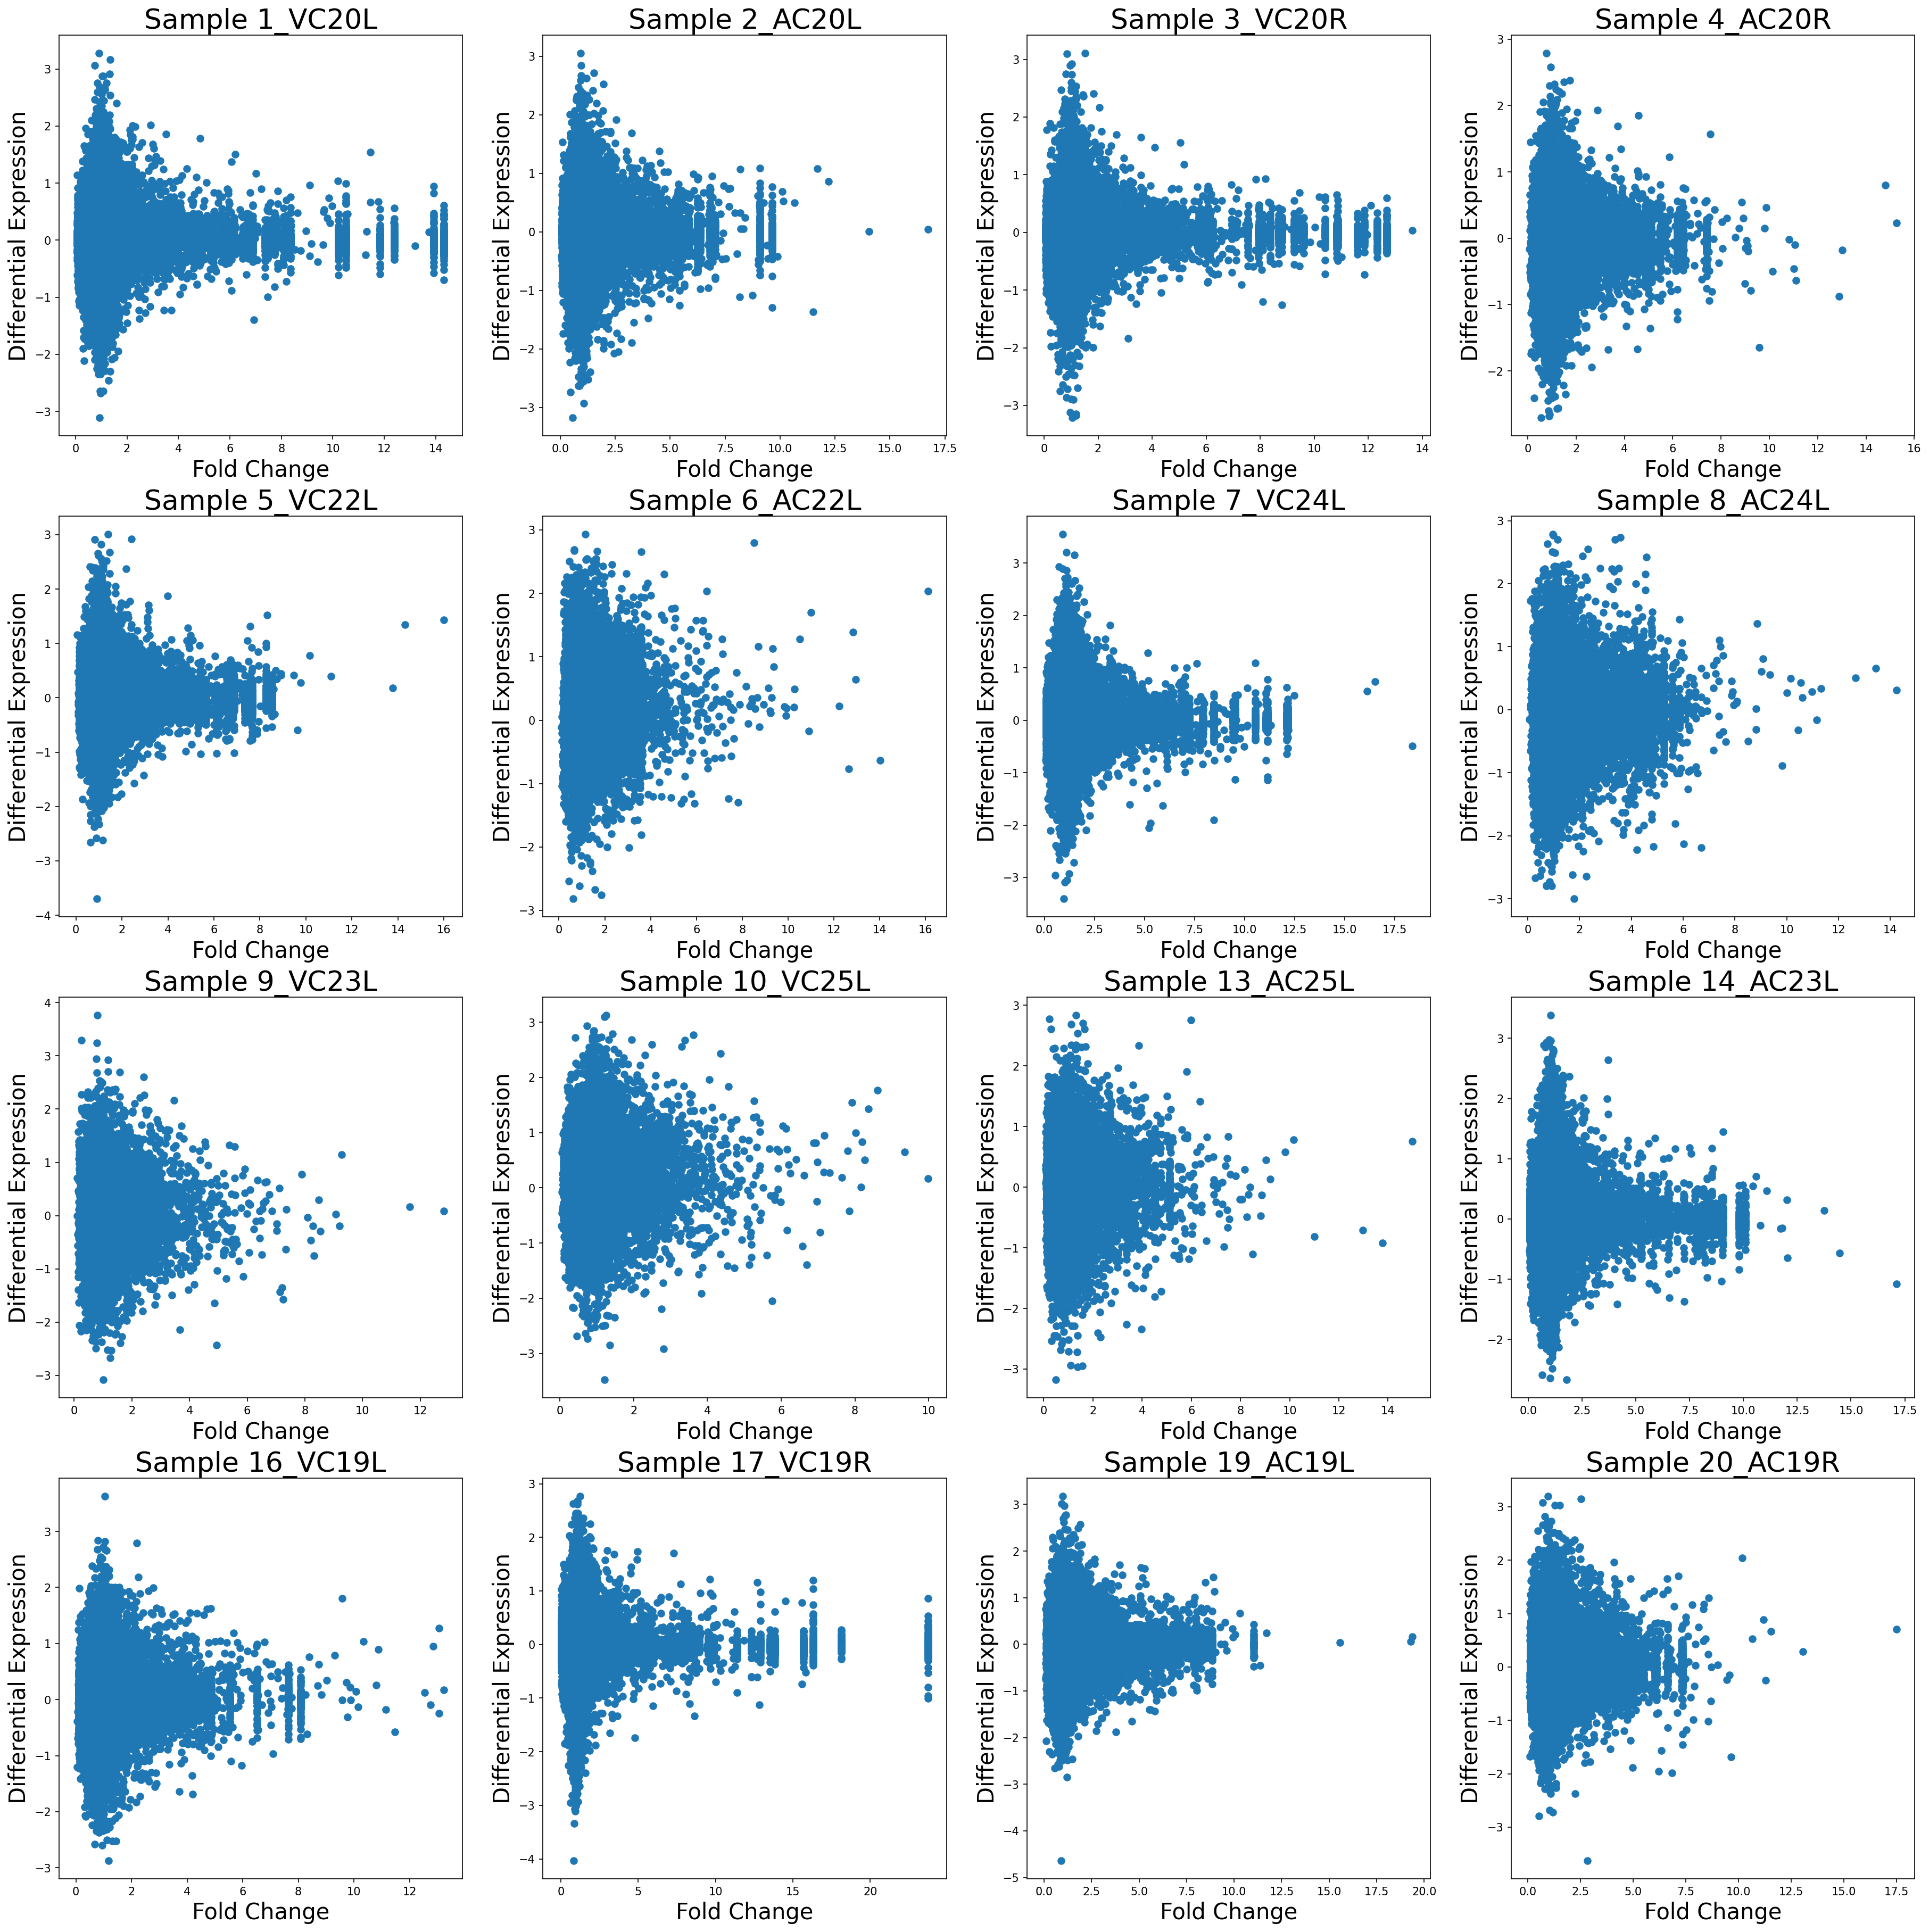

In [29]:
dictionary = readDict('F:/FigureCalculations/Figure4/foldChange_WithinSample')
folderName = 'IndividualSamples'

diffExpVSfoldChange(dictionary, sampleNameLst, folderName)

Only considering the two last: ['. (L)_16_VC19L_1_VC20L', '.h5ad'].
Only considering the two last: ['. (L)_16_VC19L_1_VC20L', '.h5ad'].
Only considering the two last: ['. (L)_19_AC19L_2_AC20L', '.h5ad'].
Only considering the two last: ['. (L)_19_AC19L_2_AC20L', '.h5ad'].
Only considering the two last: ['. (R)_17_VC19R_3_VC20R', '.h5ad'].
Only considering the two last: ['. (R)_17_VC19R_3_VC20R', '.h5ad'].
Only considering the two last: ['. (R)_20_AC19R_4_AC20R', '.h5ad'].
Only considering the two last: ['. (R)_20_AC19R_4_AC20R', '.h5ad'].


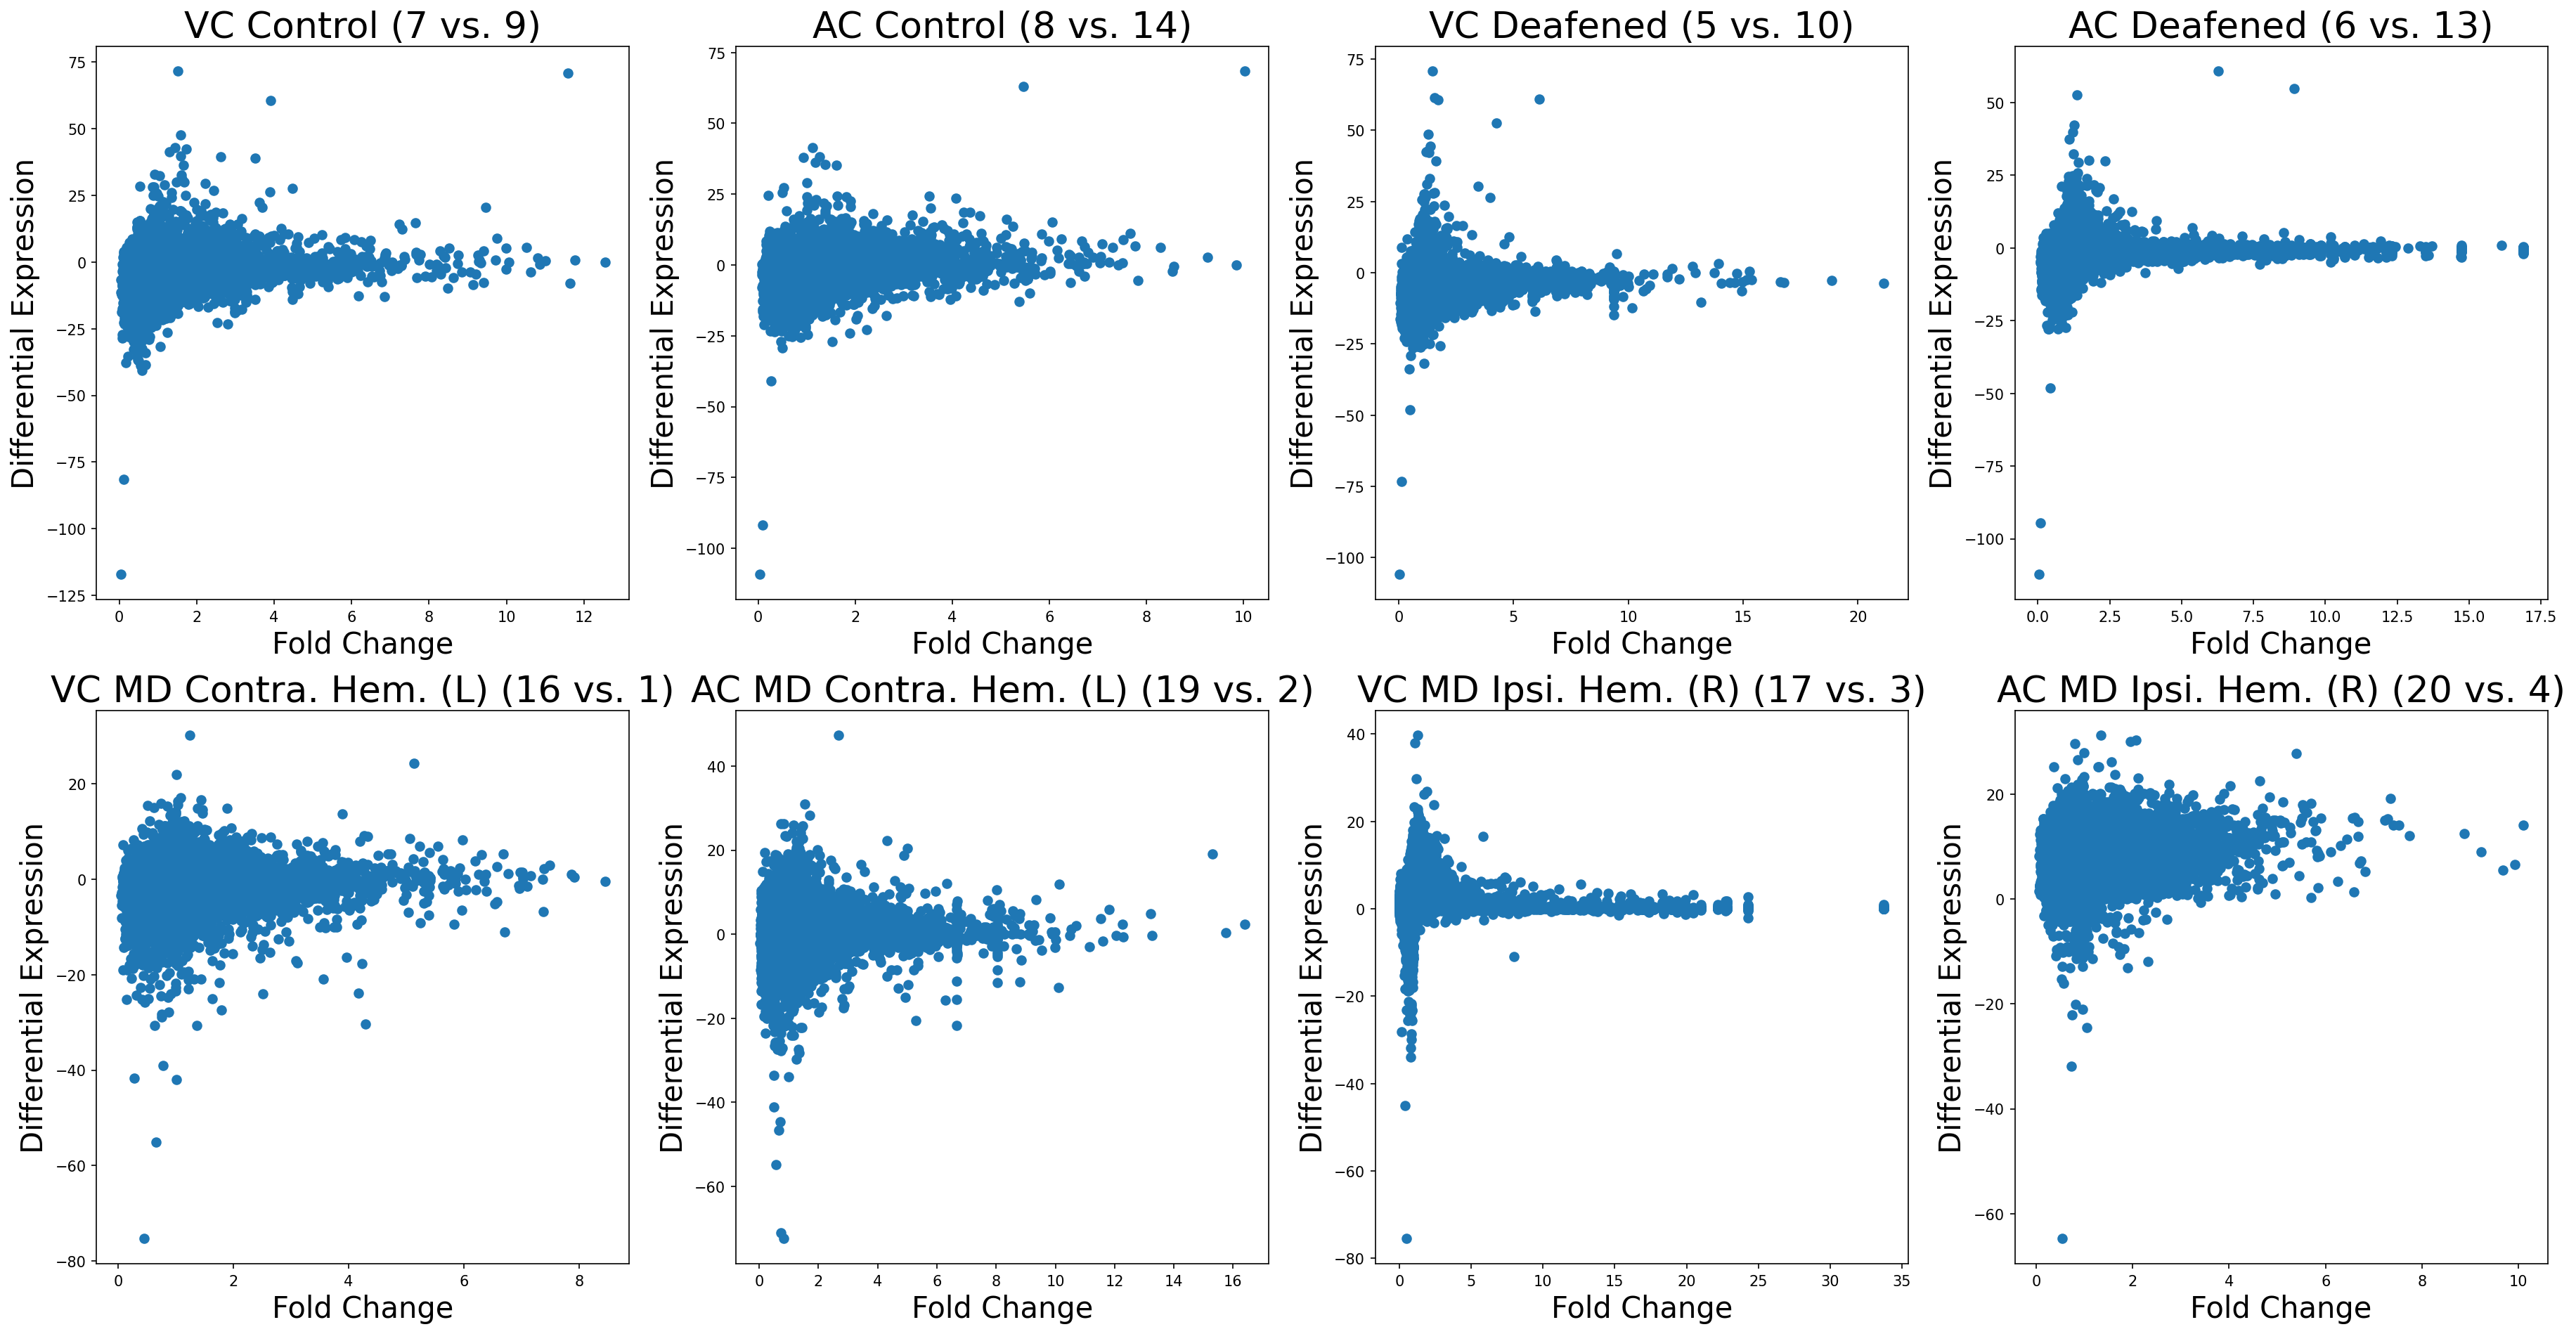

In [42]:
dictionary = readDict('F:/FigureCalculations/Figure4/foldChange_BiologicalReplicaSamples')
folderName = 'BiologicalReplicaSamples'

diffExpVSfoldChange(dictionary, bioRepComparisonLst, folderName)

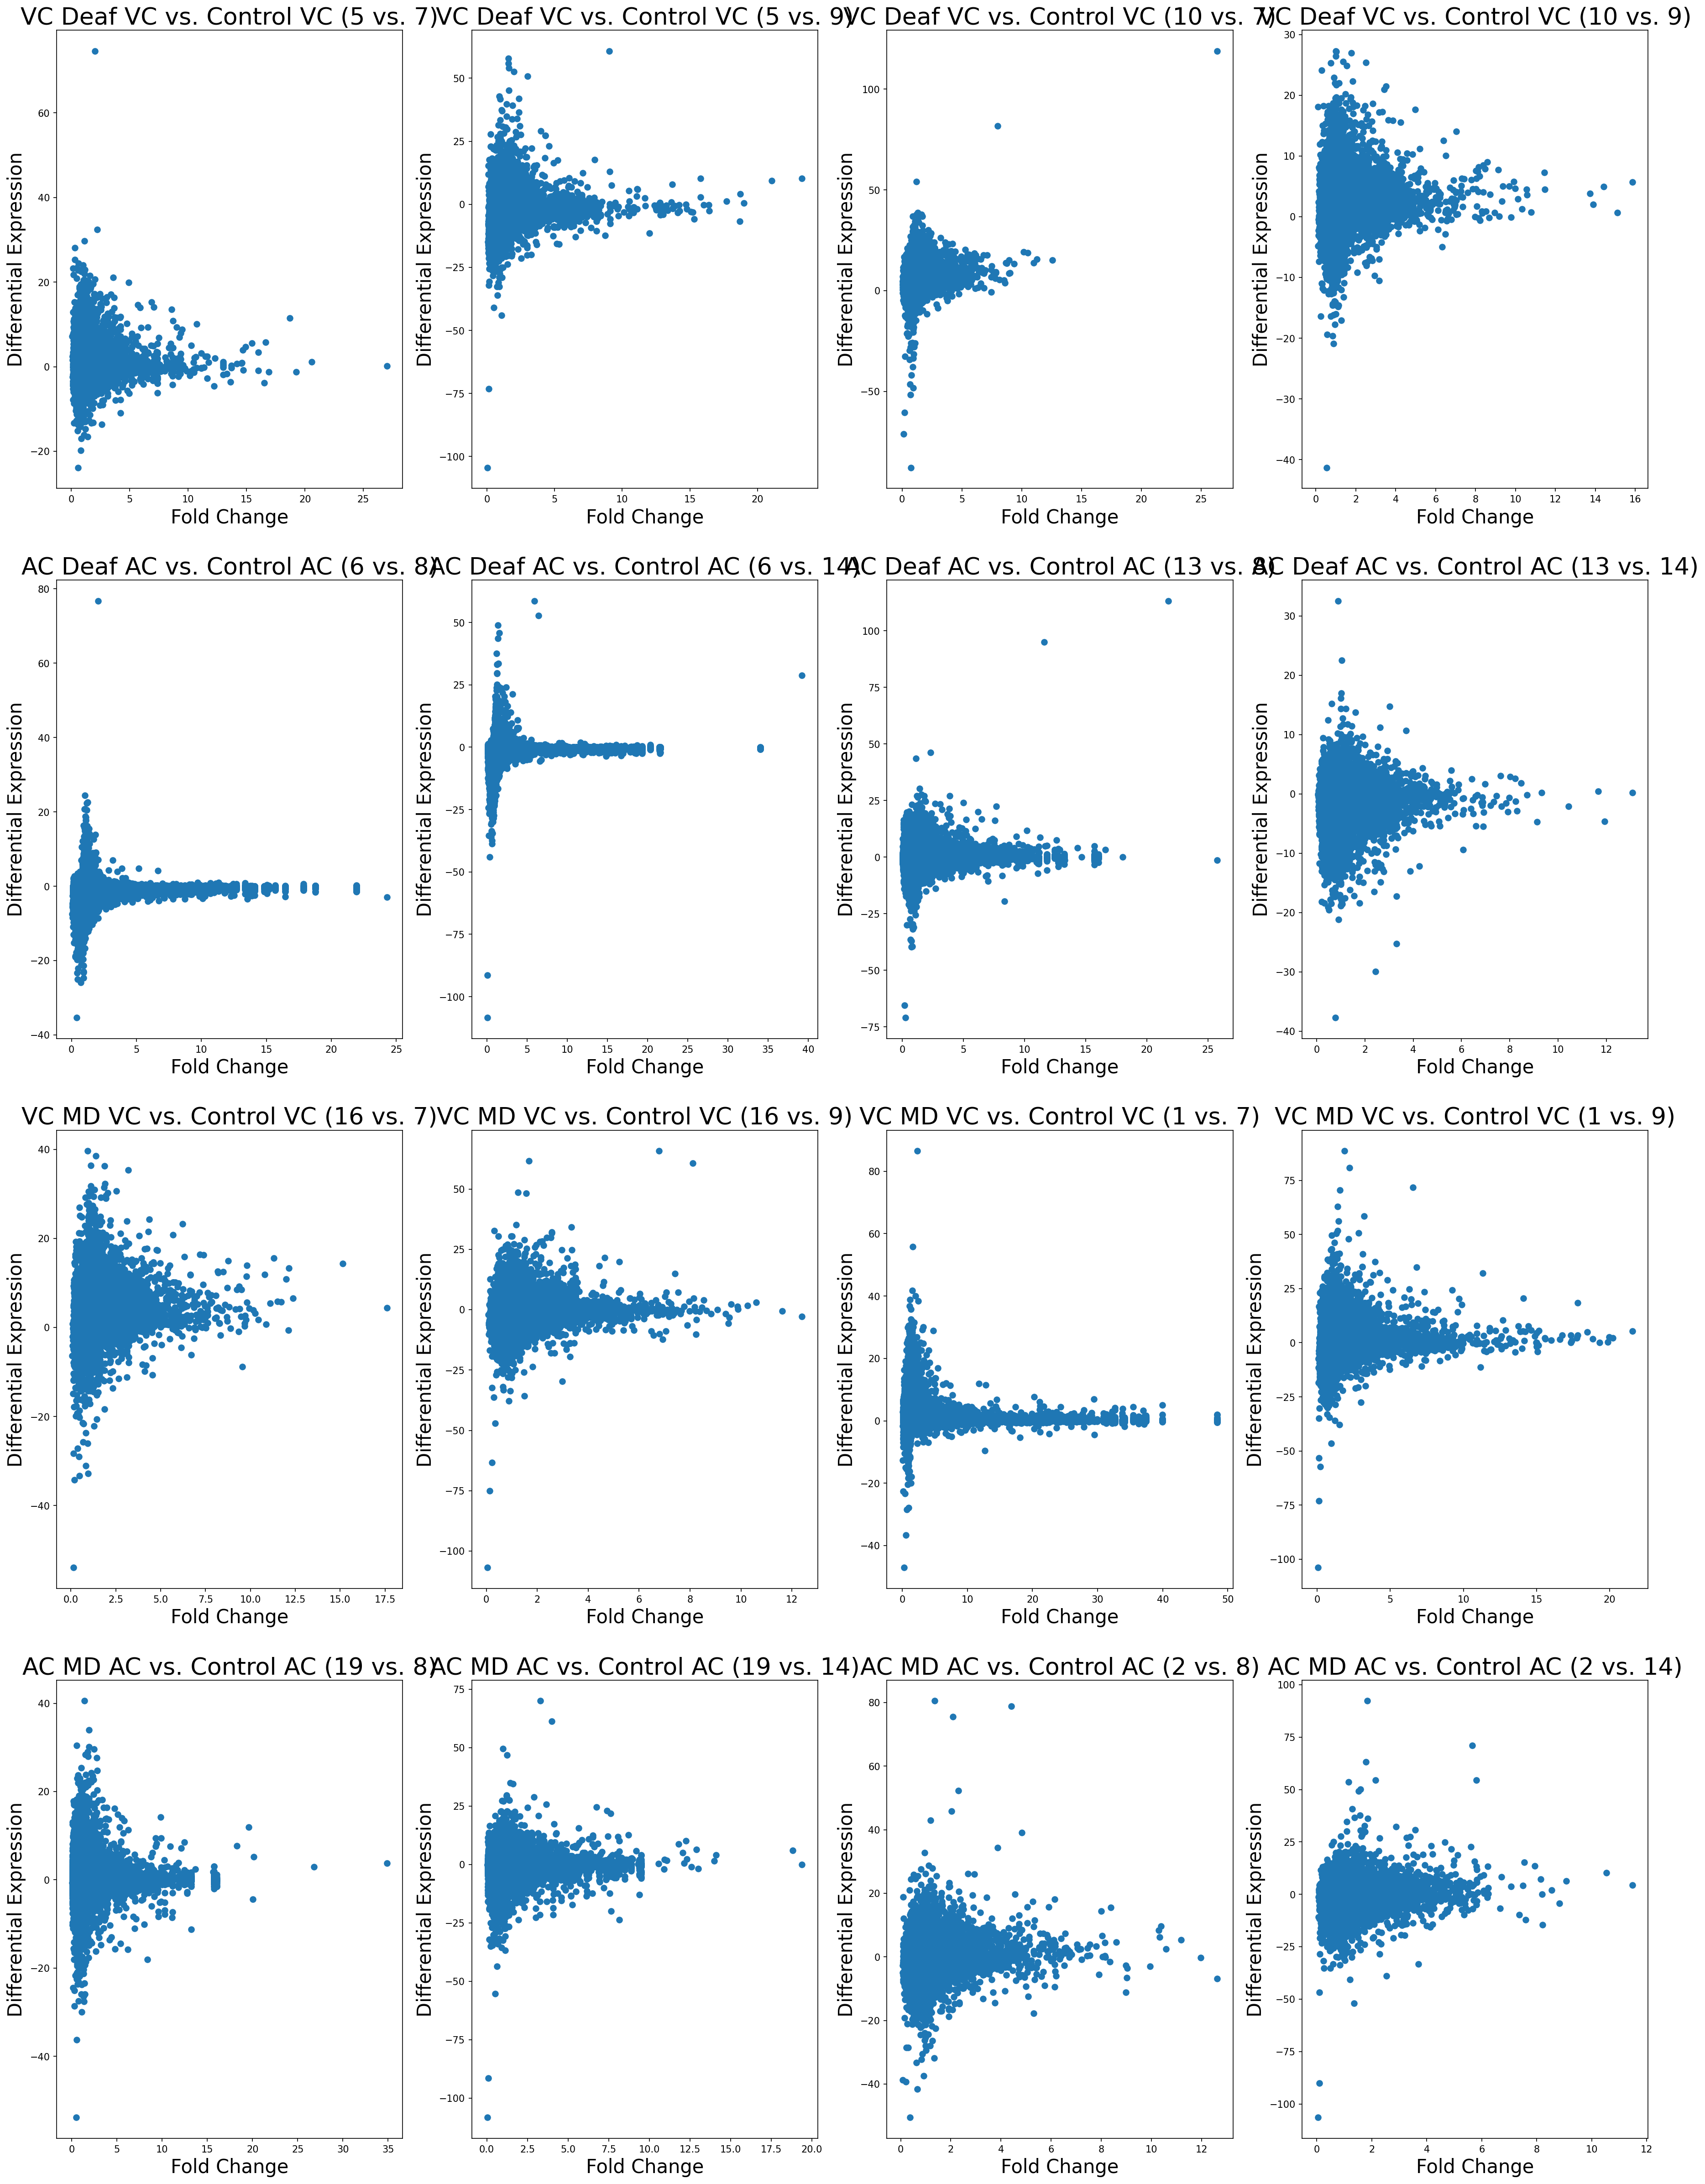

In [43]:
dictionary = readDict('F:/FigureCalculations/Figure4/foldChange_PlasticityComparisons')
folderName = 'PlasticityComparisons'

diffExpVSfoldChange(dictionary, plastComparLst, folderName)

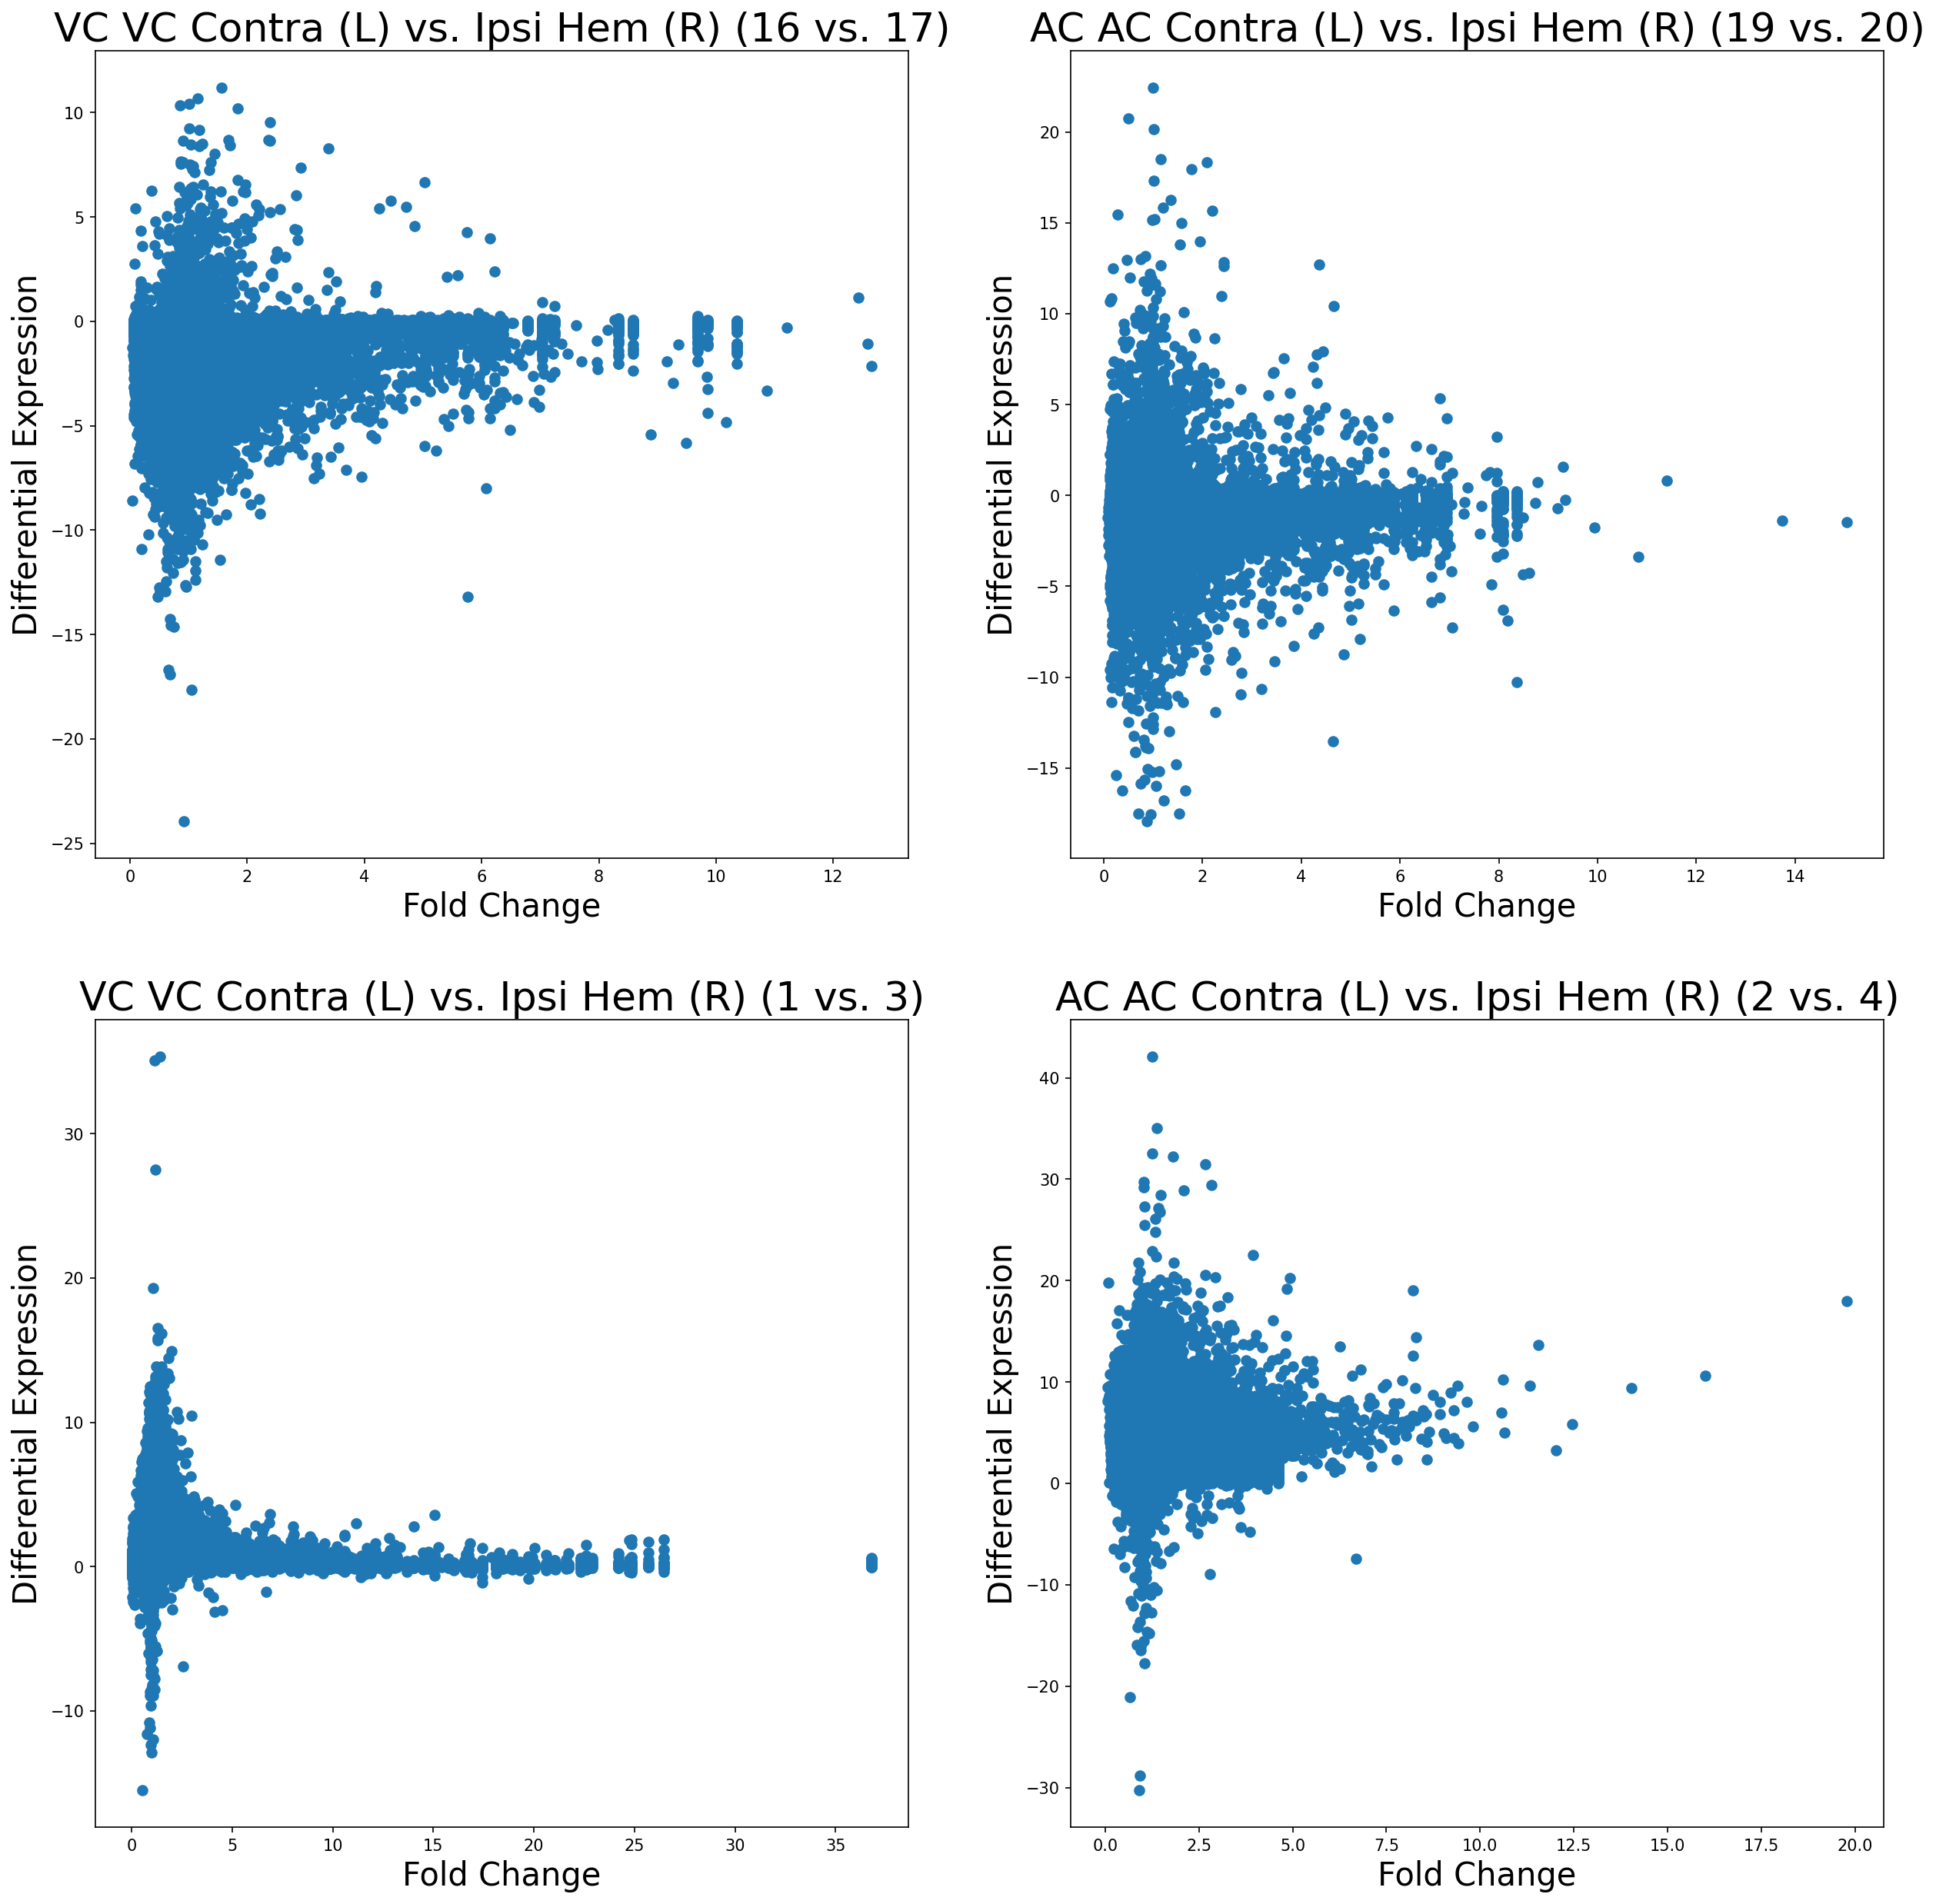

In [51]:
dictionary = readDict('F:/FigureCalculations/Figure4/foldChange_HemiComparisons')
folderName = 'HemisphericComparisons'

diffExpVSfoldChange(dictionary, hemComparLst, folderName)

## Dot Plot

In [5]:
'''SAMPLE COMPARISON LISTS'''

sampleNameLst = [['VC MD Contra. Hem. (L)', '1_VC20L'], ['AC MD Contra. Hem. (L)', '2_AC20L'], 
                 ['VC MD Ipsi. Hem. (R)', '3_VC20R'], ['AC MD Ipsi. Hem. (R)', '4_AC20R'], 
                 ['VC Deafened', '5_VC22L'], ['AC Deafened', '6_AC22L'], ['VC Control', '7_VC24L'],
                 ['AC Control', '8_AC24L'], ['VC Control', '9_VC23L'], ['VC Deafened', '10_VC25L'], 
                 ['AC Deafened', '13_AC25L'], ['AC Control', '14_AC23L'], ['VC MD Contra. Hem. (L)', '16_VC19L'], 
                 ['VC MD Ipsi. Hem. (R)', '17_VC19R'], ['AC MD Contra. Hem. (L)', '19_AC19L'], 
                 ['AC MD Ipsi. Hem. (R)', '20_AC19R']]

bioRepComparisonLst = [['VC Control', '7_VC24L', '9_VC23L'], ['AC Control', '8_AC24L', '14_AC23L'], 
                       ['VC Deafened', '5_VC22L', '10_VC25L'], ['AC Deafened', '6_AC22L', '13_AC25L'], 
                       ['VC MD Contra. Hem. (L)', '16_VC19L', '1_VC20L'], ['AC MD Contra. Hem. (L)', '19_AC19L', '2_AC20L'], 
                       ['VC MD Ipsi. Hem. (R)', '17_VC19R', '3_VC20R'], ['AC MD Ipsi. Hem. (R)', '20_AC19R', '4_AC20R']]

plastComparLst = [['VC Deaf vs. Control', '5_VC22L', '7_VC24L'], ['VC Deaf vs. Control', '5_VC22L', '9_VC23L'], 
                  ['VC Deaf vs. Control', '10_VC25L', '7_VC24L'], ['VC Deaf vs. Control', '10_VC25L', '9_VC23L'],
                  ['AC Deaf vs. Control', '6_AC22L', '8_AC24L'], ['AC Deaf vs. Control', '6_AC22L', '14_AC23L'],
                  ['AC Deaf vs. Control', '13_AC25L', '8_AC24L'], ['AC Deaf vs. Control', '13_AC25L', '14_AC23L'],
                  ['VC MD vs. Control', '16_VC19L', '7_VC24L'], ['VC MD vs. Control', '16_VC19L', '9_VC23L'],
                  ['VC MD vs. Control', '1_VC20L', '7_VC24L'], ['VC MD vs. Control', '1_VC20L', '9_VC23L'],
                  ['AC MD vs. Control', '19_AC19L', '8_AC24L'], ['AC MD vs. Control', '19_AC19L', '14_AC23L'],
                  ['AC MD vs. Control', '2_AC20L', '8_AC24L'], ['AC MD vs. Control', '2_AC20L', '14_AC23L']]

hemComparLst = [['VC Contra (L) vs. Ipsi Hem (R)', '16_VC19L', '17_VC19R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '19_AC19L', '20_AC19R'], 
                ['VC Contra (L) vs. Ipsi Hem (R)', '1_VC20L', '3_VC20R'], 
                ['AC Contra (L) vs. Ipsi Hem (R)', '2_AC20L','4_AC20R']]

In [6]:
# Reading in the sample dictionaries
diffExp_withinSample = readDict('F:/FigureCalculations/Figure4/diffExp_WithinSample')
diffExp_bioRep = readDict('F:/FigureCalculations/Figure4/diffExp_BiologicalReplicaSamples')
diffExp_plastCompar = readDict('F:/FigureCalculations/Figure4/diffExp_PlasticityComparisons')
diffExp_hemiCompar =  readDict('F:/FigureCalculations/Figure4/diffExp_HemiComparisons')

# List of lists
dictLsts = [diffExp_withinSample, diffExp_bioRep, diffExp_plastCompar, diffExp_hemiCompar]
sampleLsts = [sampleNameLst, bioRepComparisonLst, plastComparLst, hemComparLst]
VC_colorLst = ['maroon', 'lightcoral', 'darkred', 'red', 'tomato']
AC_colorLst = ['navy', 'skyblue', 'blue', 'deepskyblue', 'royalblue']

In [154]:
'''DOT PLOT CONTAINING ALL COMPARISONS'''

# Calculating plot coordinates, point colors, and sample labels 
x_coords, y_coords, pointColors, sample_labels = dotPlotCalcs(dictLsts, sampleLsts, VC_colorLst, AC_colorLst, None)

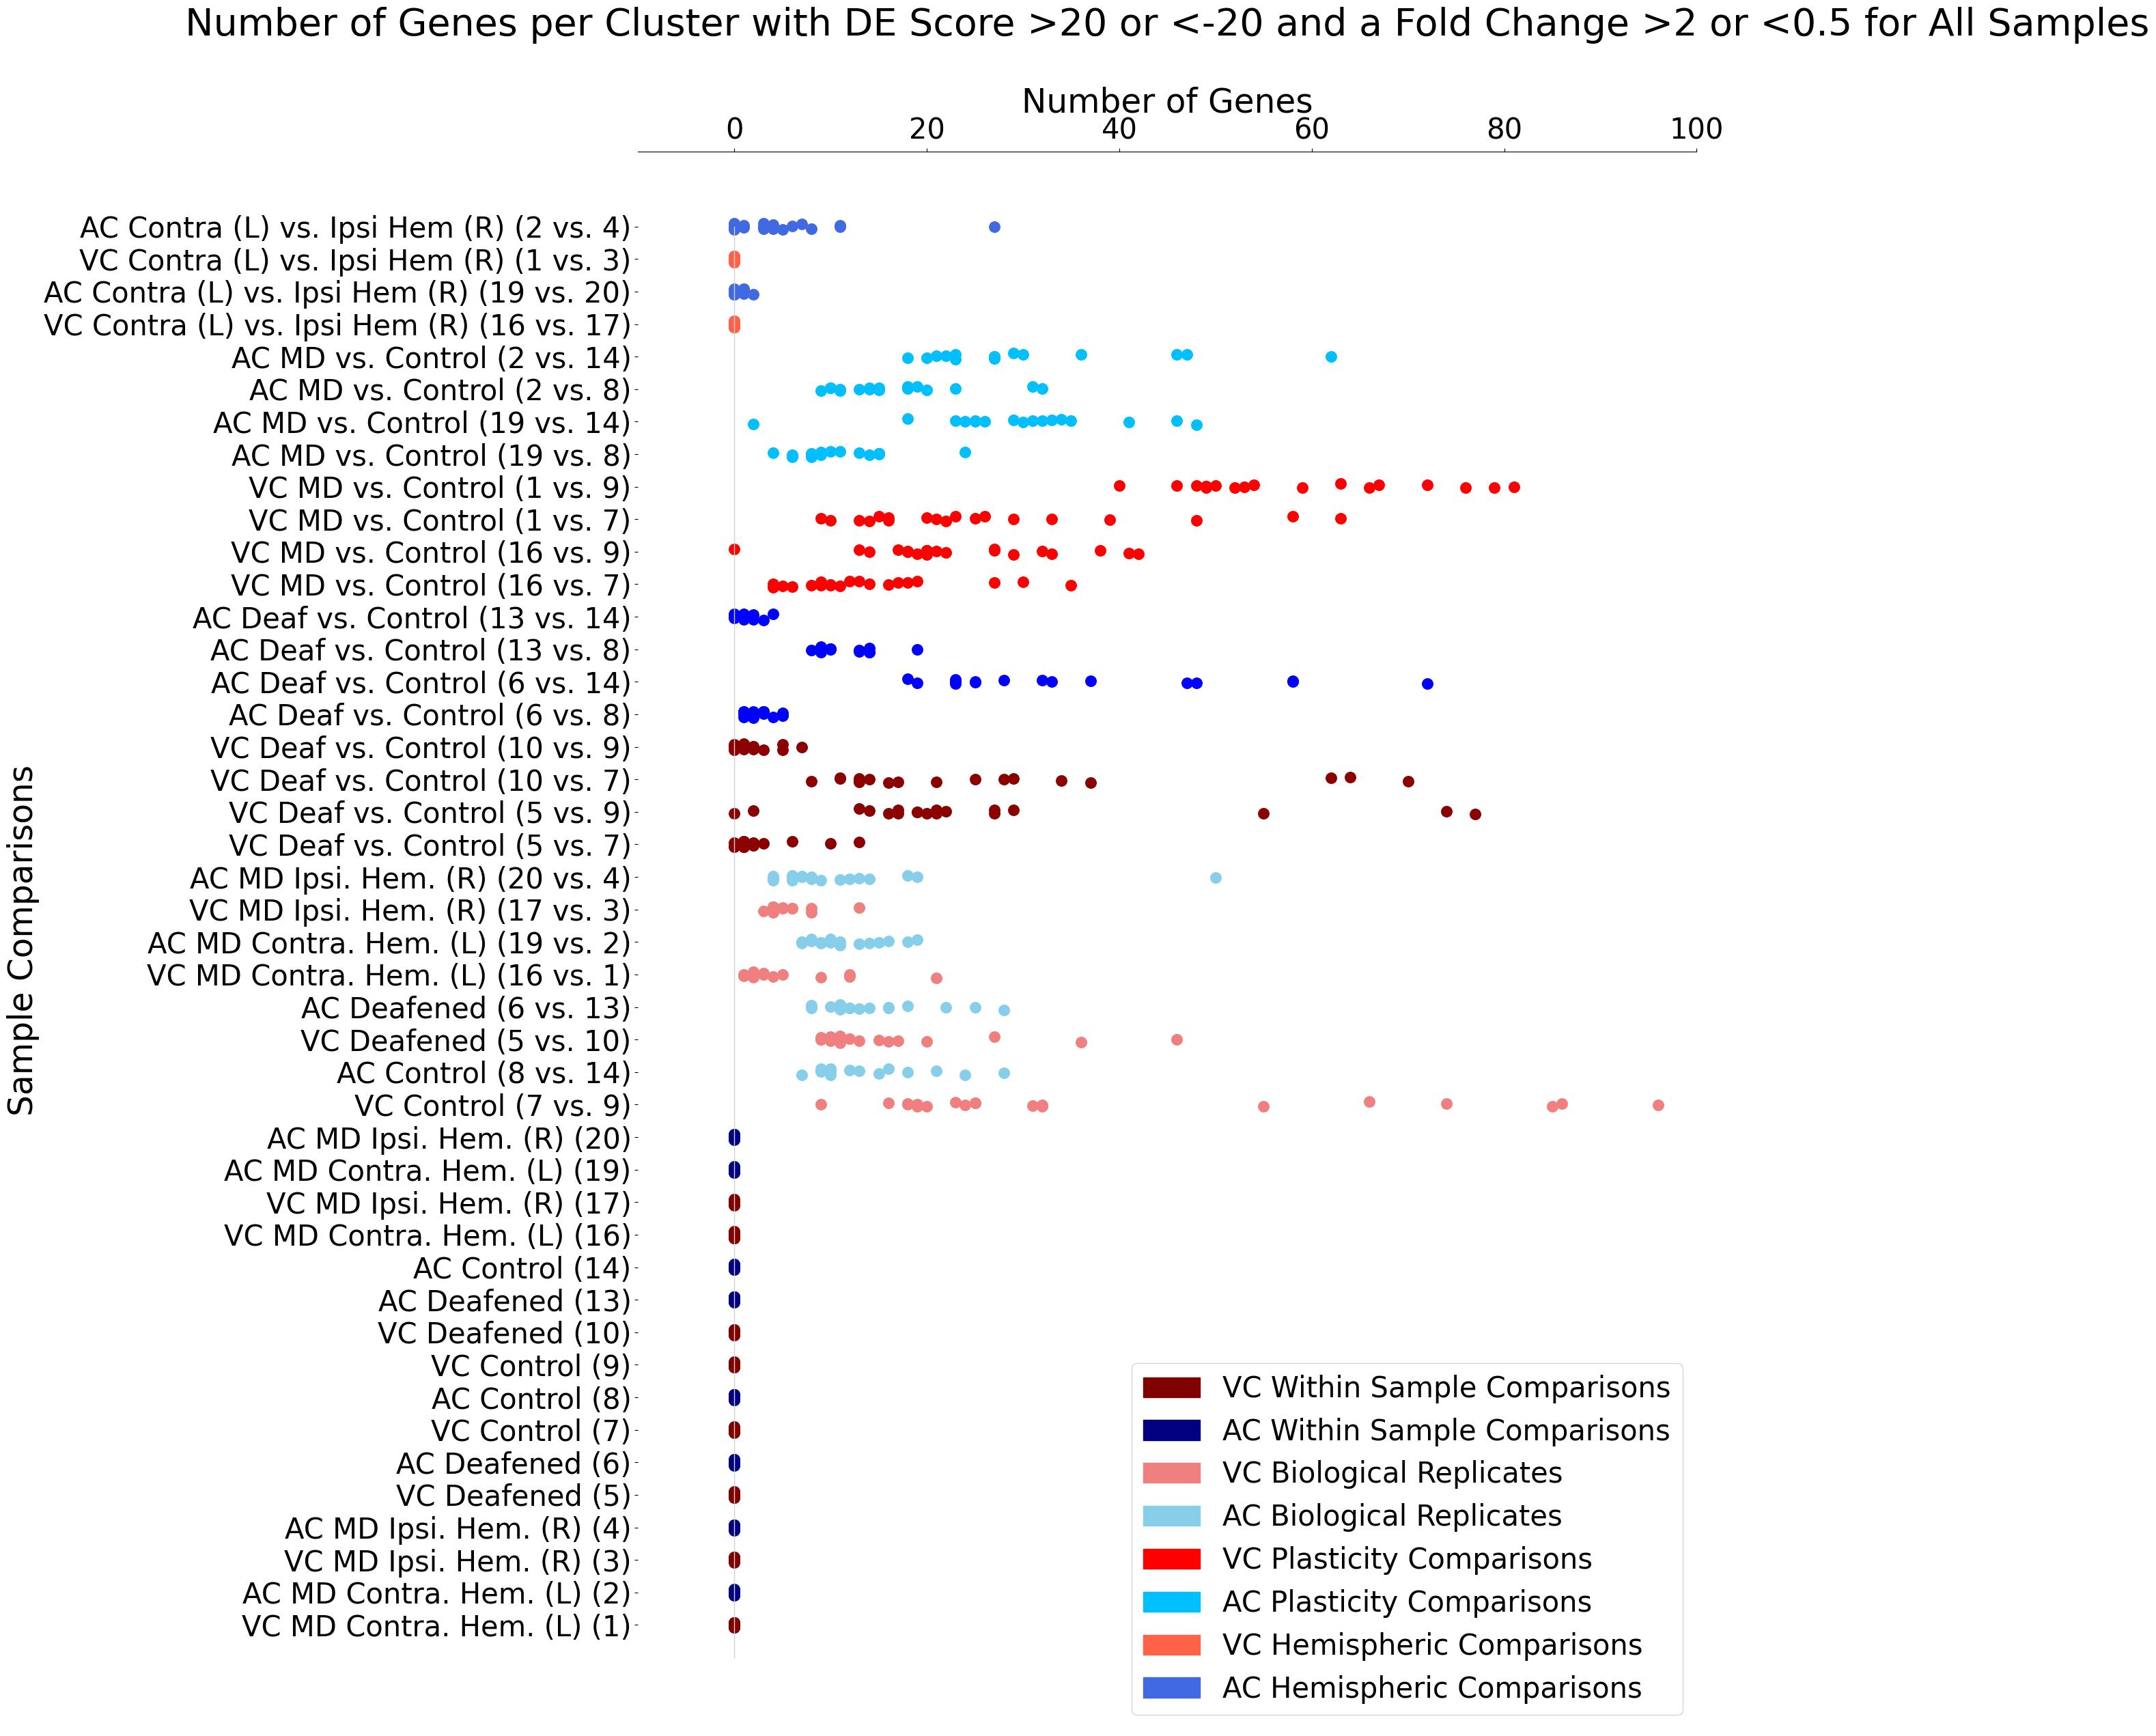

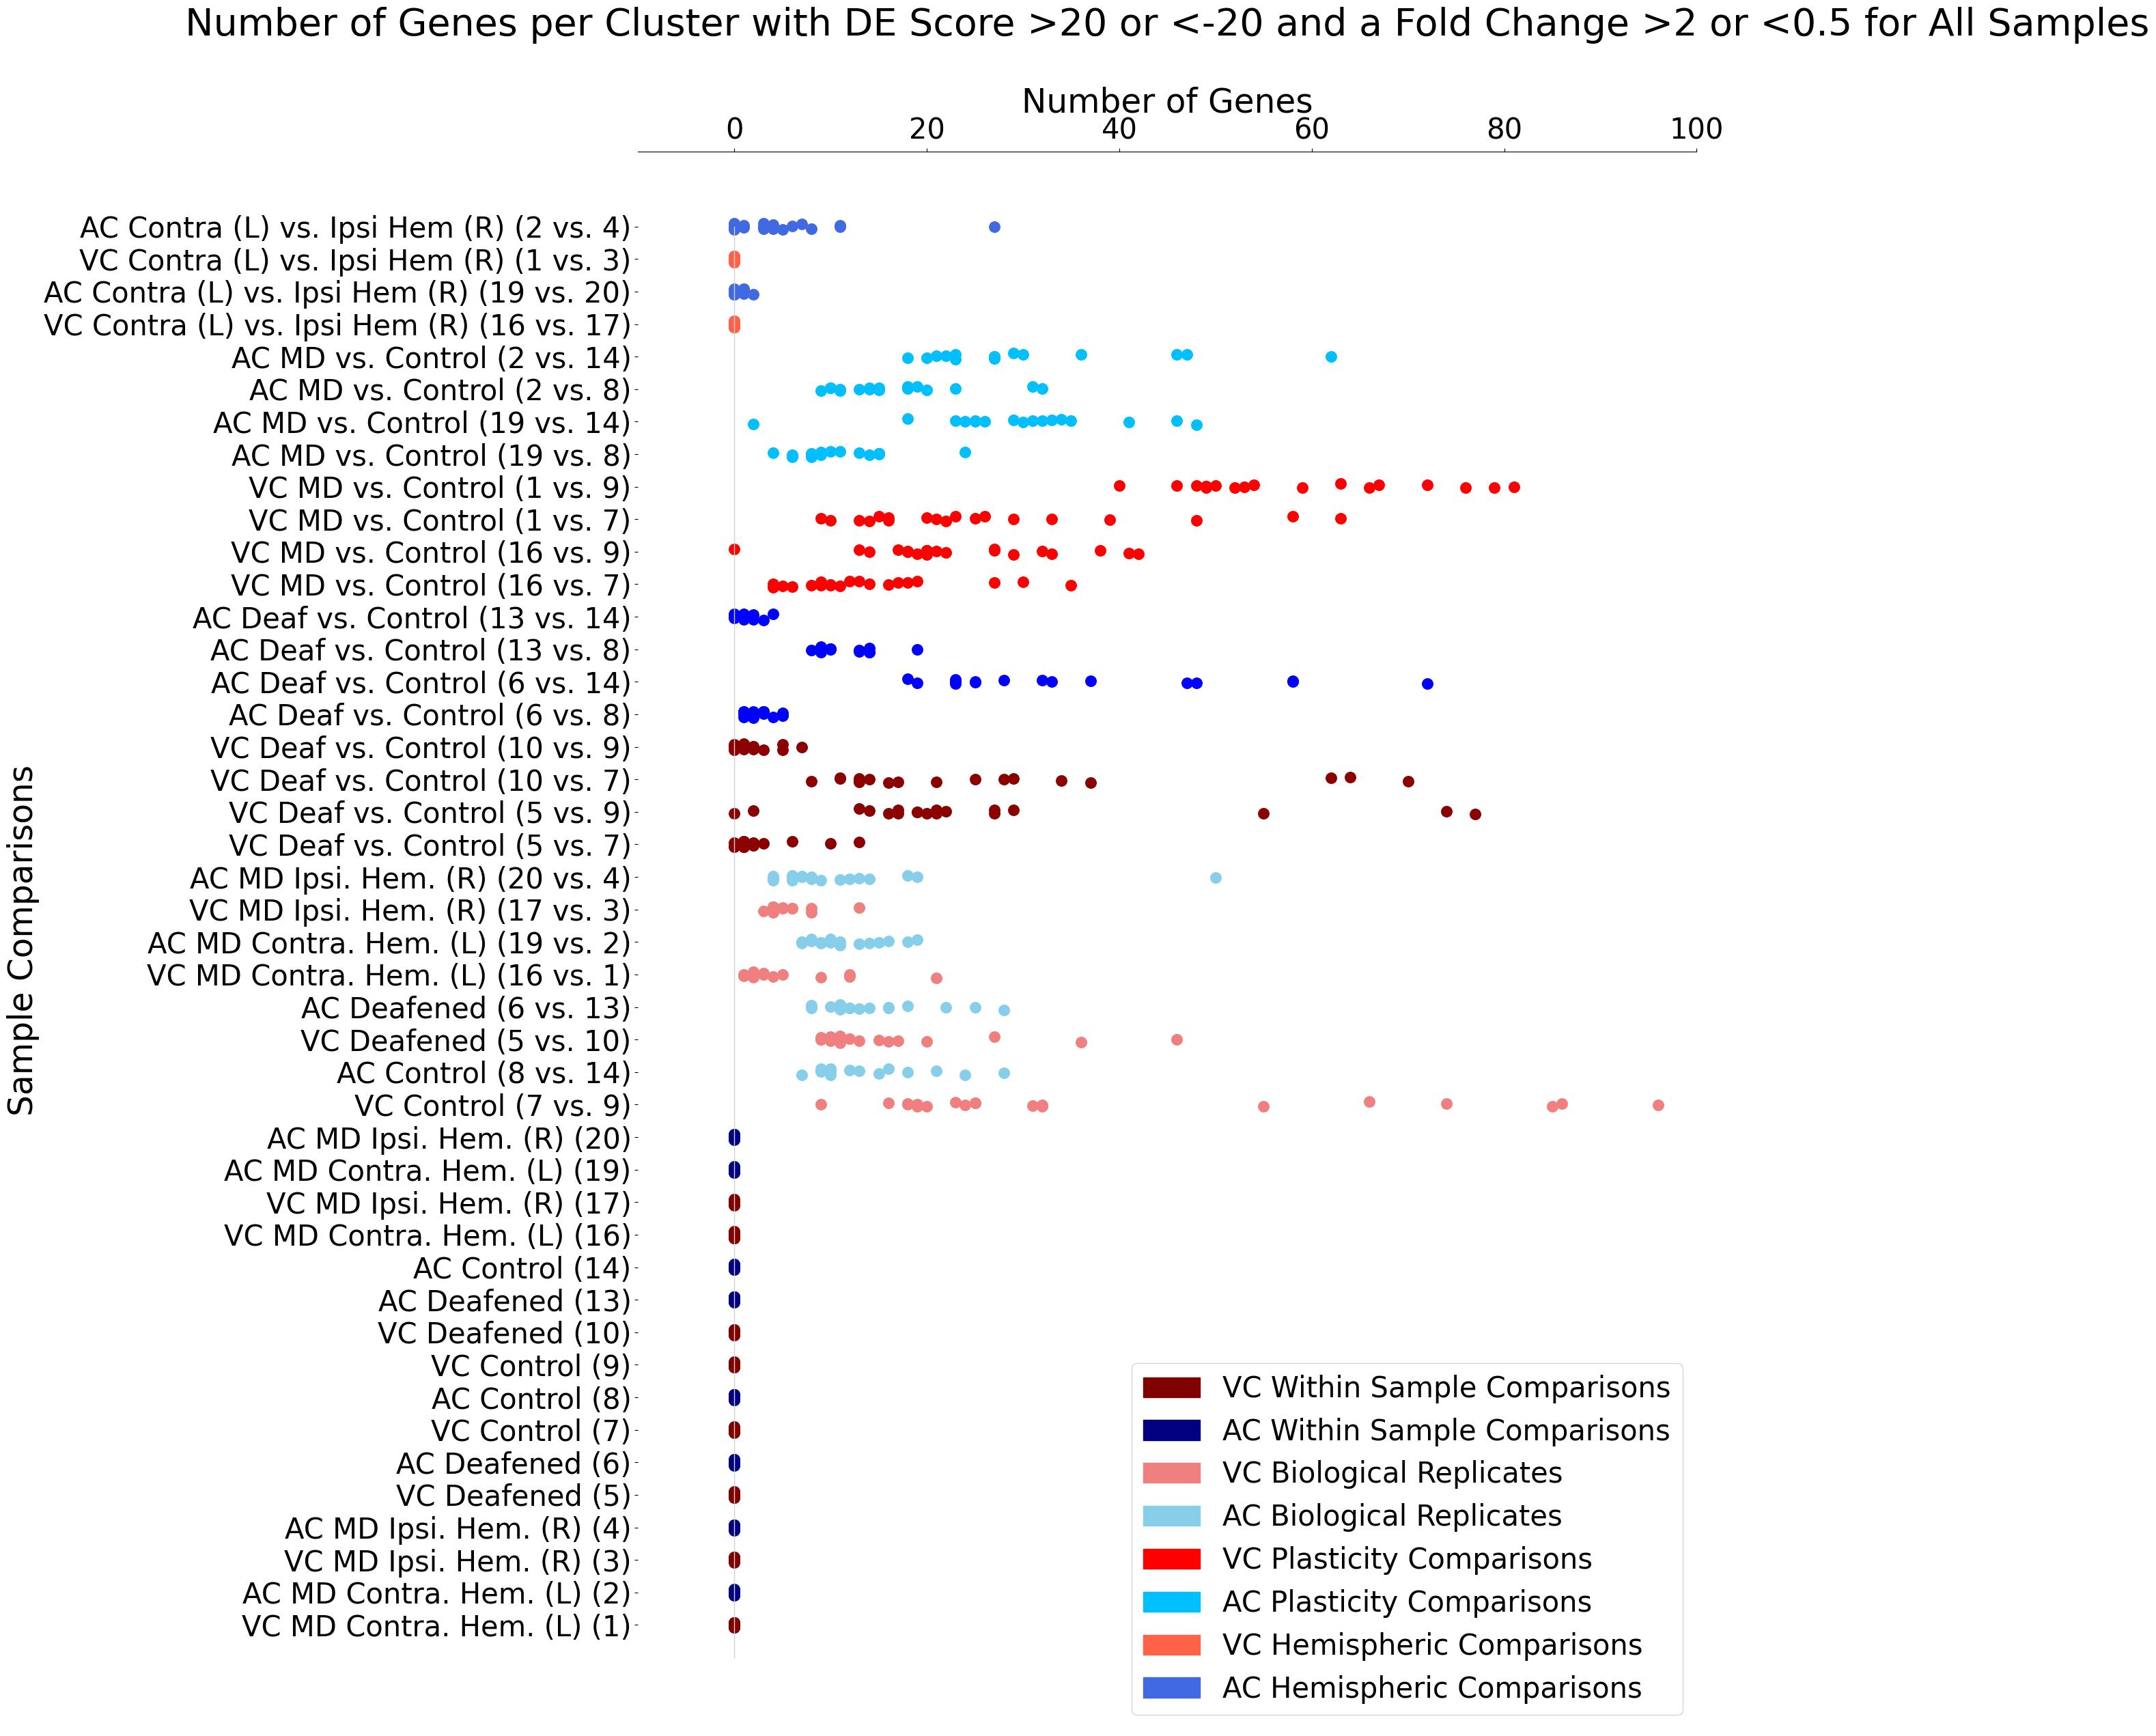

In [155]:
# Plotting graphs 
createDotPlot((20, 30), x_coords, y_coords, pointColors, sample_labels, VC_colorLst, AC_colorLst, 'DEGenes_AllSamples', 'All Samples')

In [10]:
'''DOT PLOT CONTAINING ONLY THE SAME SEX MOUSE COMPARISONS'''

# Calculating plot coordinates, point colors, and sample labels 
x_coords_ss, y_coords_ss, pointColors_ss, sample_labels_ss = dotPlotCalcs(dictLsts, sampleLsts, VC_colorLst, AC_colorLst, True)

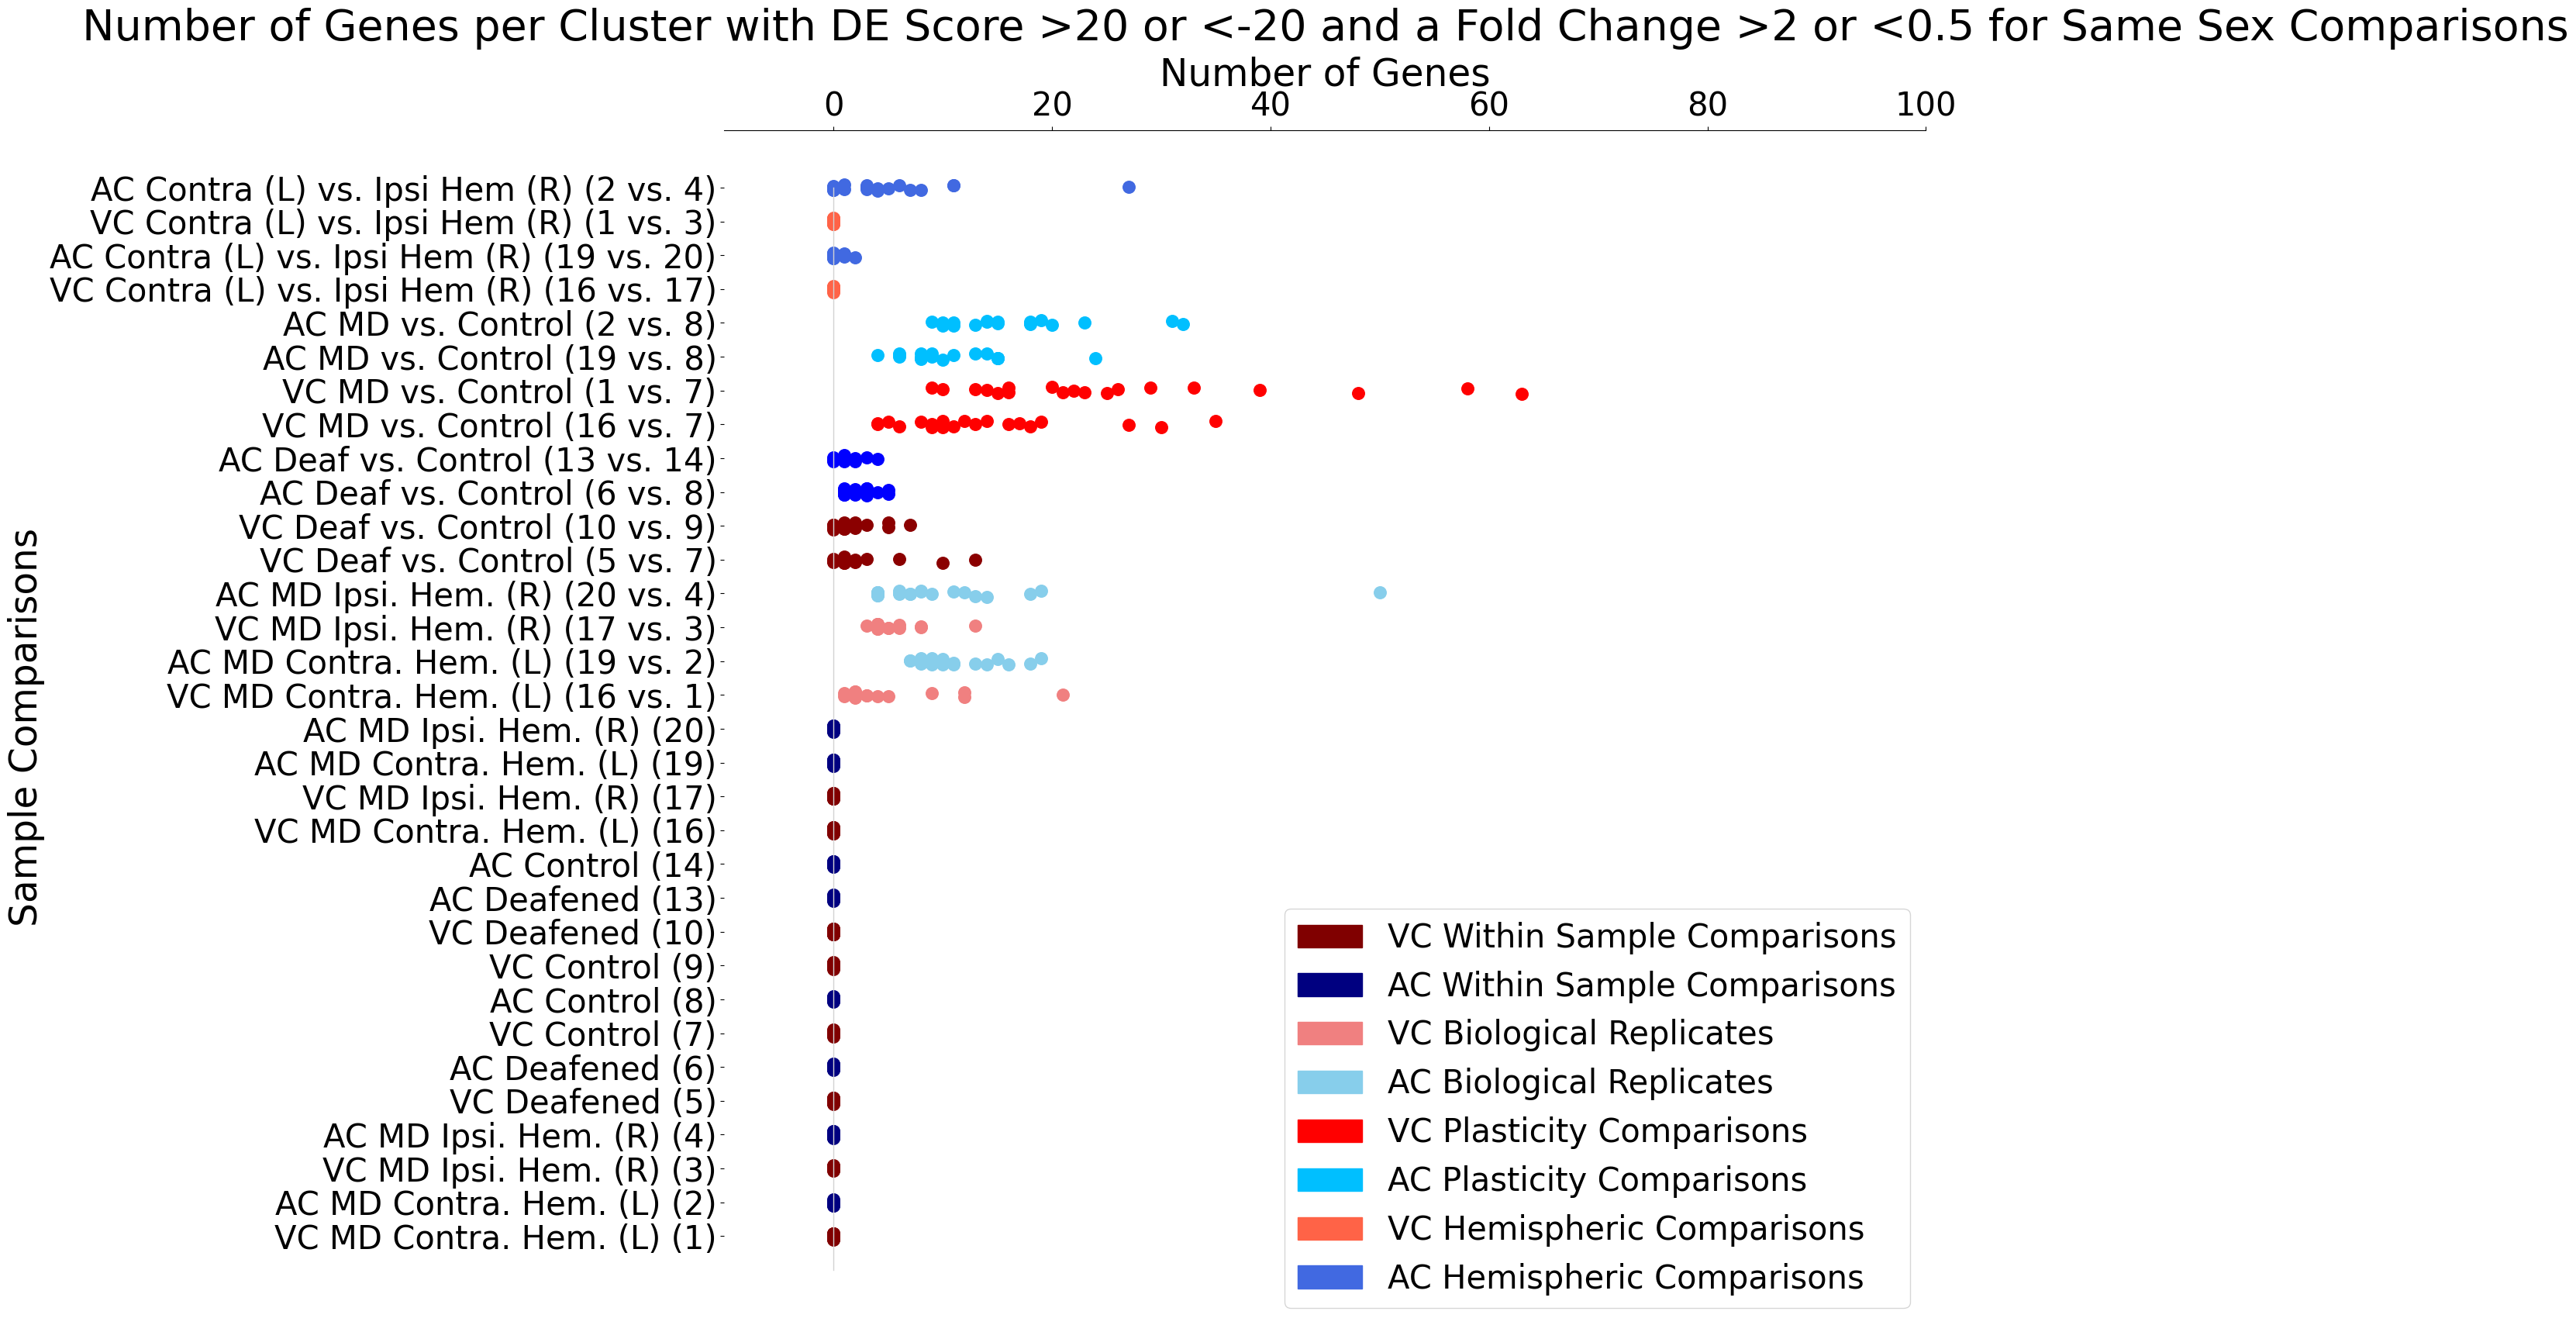

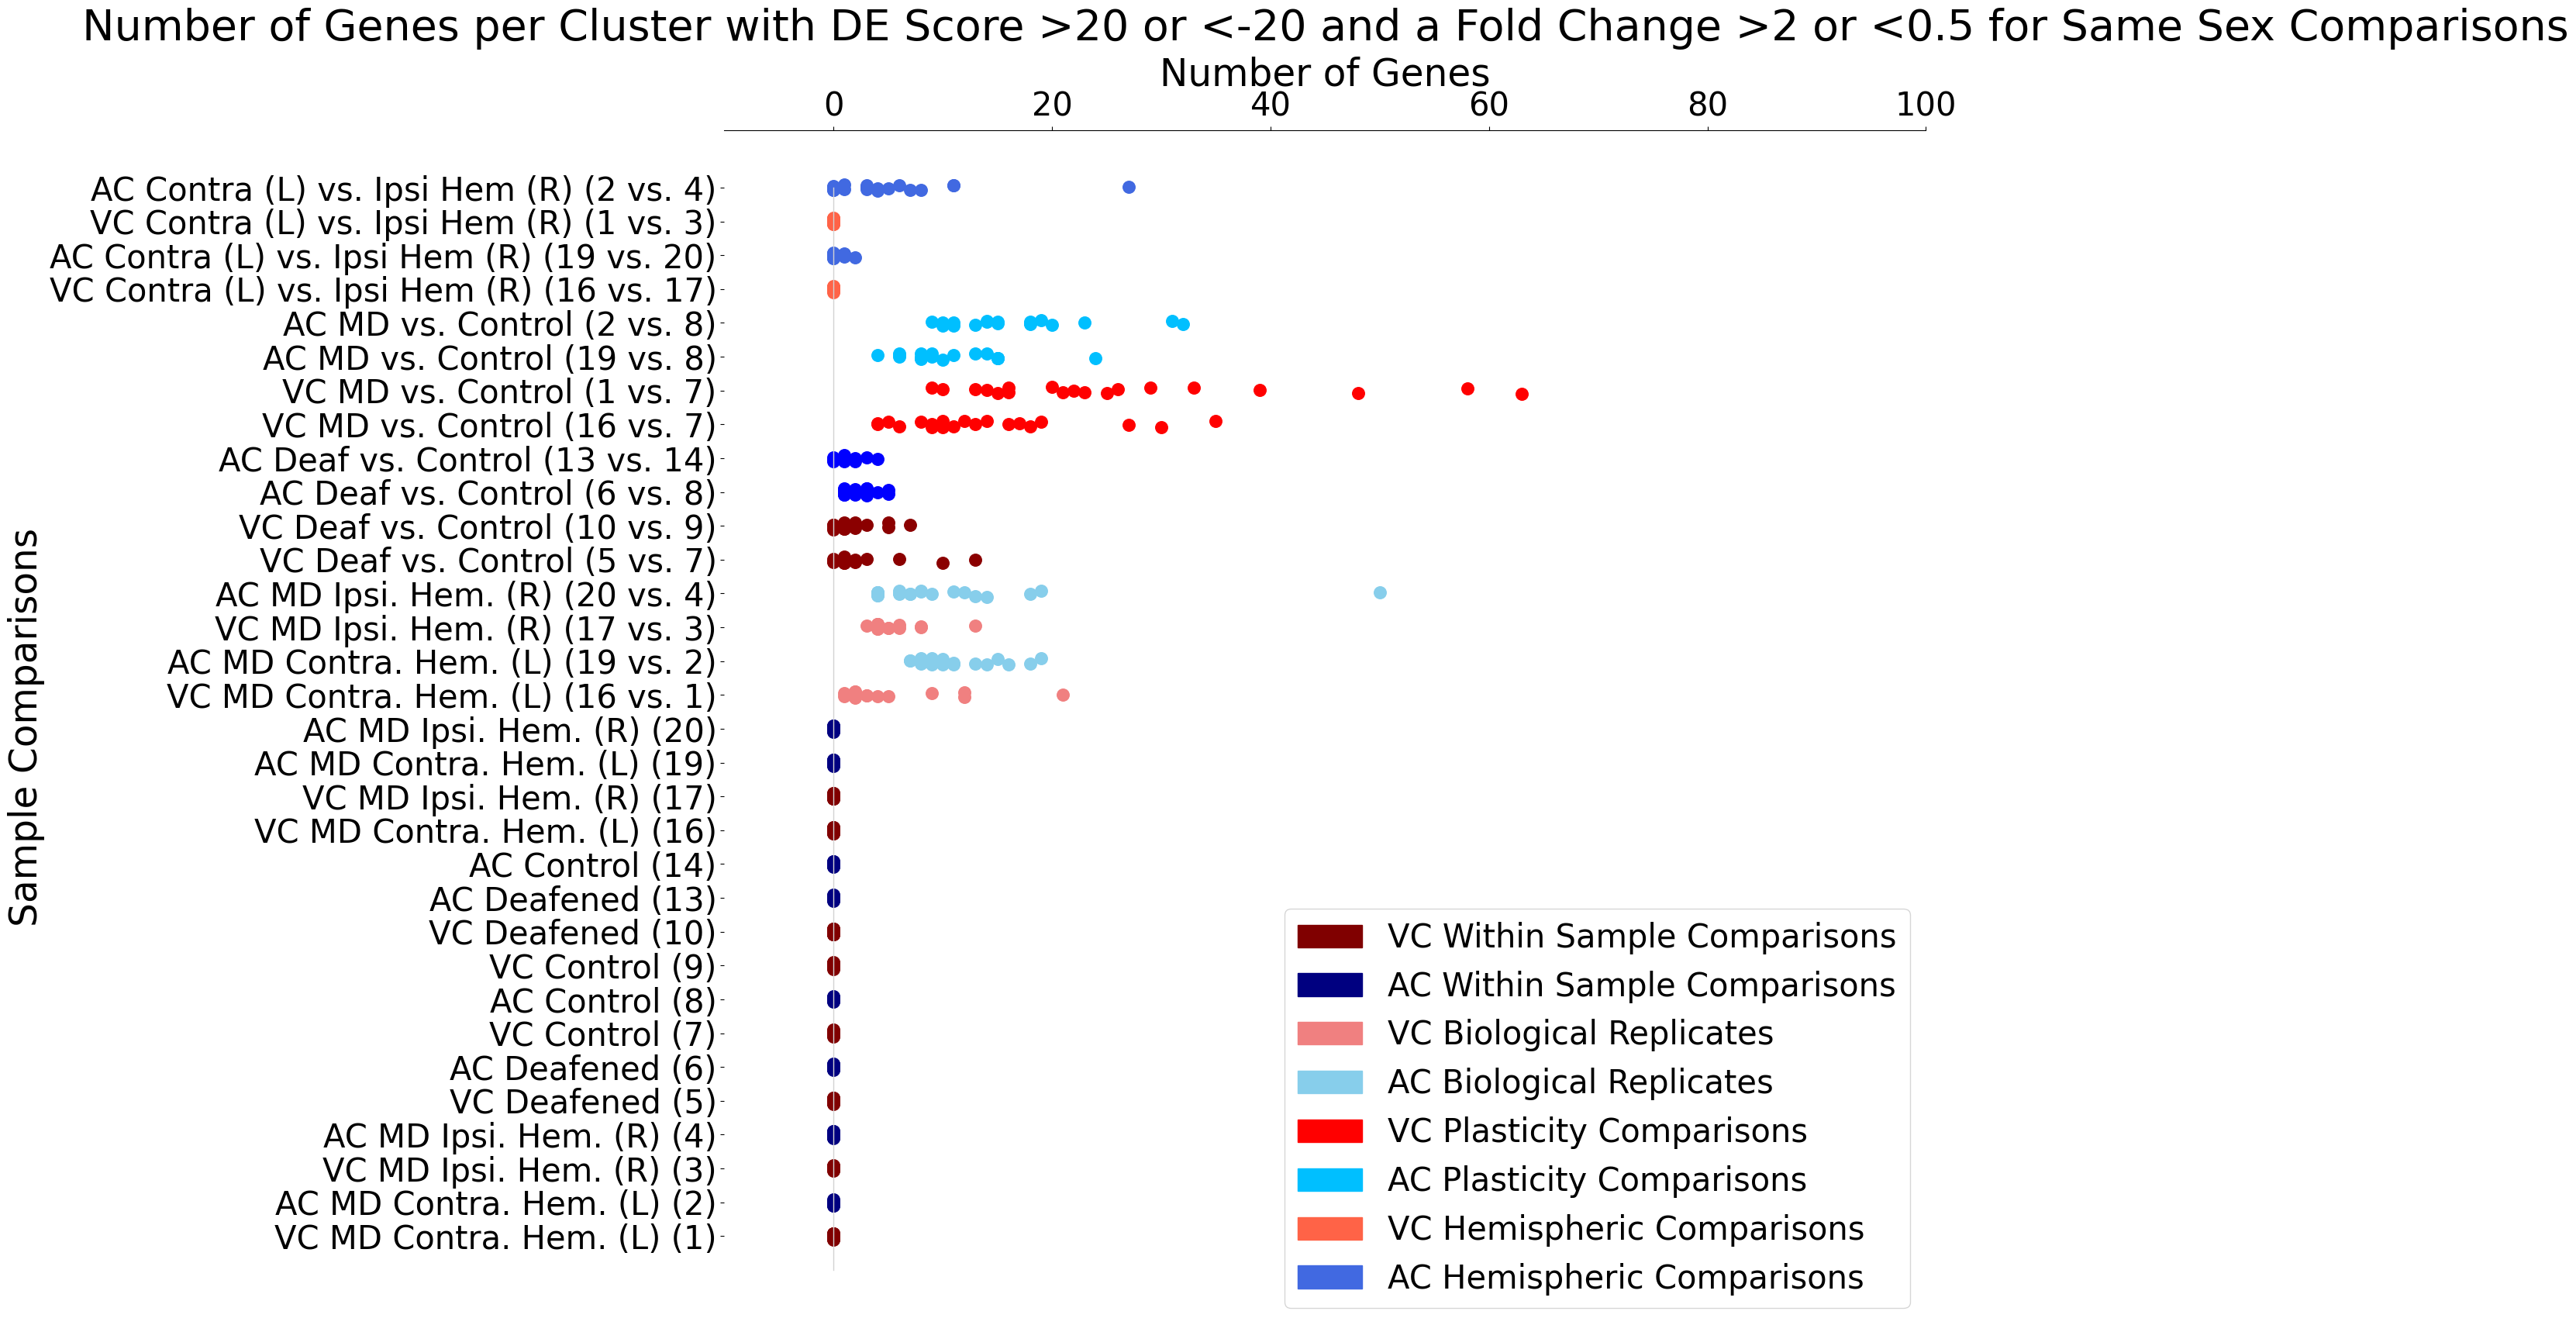

In [11]:
# Plotting graphs 
createDotPlot((20, 20), x_coords_ss, y_coords_ss, pointColors_ss, sample_labels_ss, VC_colorLst, AC_colorLst, 'DEGenes_SameSex', 'Same Sex Comparisons')